In [1]:
!pip install keras-tcn
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


Librerias a Utilizar

In [64]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Concatenate, Input,  BatchNormalization, LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt
import os
import warnings
from tcn import TCN
import math as m
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.utils import plot_model
import pdb


Lectura de Dataset preprocesado

In [52]:
arch='MILSTM'
project_path='/content/drive/MyDrive/Price_Prediction'

df=pd.read_csv(project_path+'/DataCompleta_Resultados/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [53]:
# Lista de fechas a eliminar
fechas_a_eliminar = ['2015-03-26', '2015-07-08', '2015-10-12', '2015-12-17']

# Eliminar las filas con las fechas especificadas
df = df[~df['Date'].isin(fechas_a_eliminar)]

# Mostrar el DataFrame resultante
df


,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


Se utiliza solo un segmento del DataSet para pruebas

In [54]:
dfCorto = df.head(804)
dfCorto

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,2015-07-17,AMZN,0.764742,23.885000,24.271000,23.862499,24.150499,98644000,5.2,7.3,12013.4,13324.1,12327.5,111.35,2.324545,0.130323,1160904.0,101.1831,242.565
810,2015-07-17,GOOG,0.854523,32.450001,33.723400,32.250000,33.646500,223298000,5.2,7.3,12013.4,13324.1,12327.5,111.35,2.324545,0.130323,1160904.0,101.1831,242.565
811,2015-07-17,GOOGL,0.821173,34.000000,35.150002,33.900002,34.980999,257162000,5.2,7.3,12013.4,13324.1,12327.5,111.35,2.324545,0.130323,1160904.0,101.1831,242.565
812,2015-07-17,MSFT,0.820405,46.549999,46.779999,46.259998,46.619999,29467100,5.2,7.3,12013.4,13324.1,12327.5,111.35,2.324545,0.130323,1160904.0,101.1831,242.565


In [6]:
a=dfCorto['ticker_symbol']=='AAPL'
a.sum()

134

In [7]:
b=dfCorto['ticker_symbol']=='AMZN'
b.sum()

134

In [8]:
c=dfCorto['ticker_symbol']=='GOOG'
c.sum()

134

In [9]:
d=dfCorto['ticker_symbol']=='GOOGL'
d.sum()

134

In [10]:
e=dfCorto['ticker_symbol']=='MSFT'
e.sum()

134

In [11]:
f=dfCorto['ticker_symbol']=='TSLA'
f.sum()

134

Separacion de Empresas en diccionario

In [55]:
metric_labels=['Testing-MSE','Validation-MSE','testing-MAE','validation-MAE','testing-mape','validation-mape','testing-RMSE','validation-RMSE', 'testing-MPE','validation-MPE']
metrics_df=pd.DataFrame()
metrics_df['Metrics']=metric_labels
std_metrics_df=pd.DataFrame()
std_metrics_df['Metrics']=metric_labels

mse_t_p=[]
mae_t_p=[]
mape_t_p=[]
rmse_t_p=[]
mpe_t_p=[]
mse_v_p=[]
mae_v_p=[]
mape_v_p=[]
rmse_v_p=[]
mpe_v_p=[]


overall_mse_train=[]
overall_mse_val=[]
overall_std_train=[]
overall_std_val=[]

# Cálculo de métricas para cada canal de entrada y salida
t_mses = []
v_mses = []
t_maes = []
v_maes = []
t_mapes = []
v_mapes = []
t_rmses = []
v_rmses = []
t_mpes = []
v_mpes = []

metrics=[]

#save dataframe as csv
metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metrics.csv',index=False)
std_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metrics.csv',index=False)


Creacion de las secuencias de entrada y salida de cada empresa (ventana de tiempo)

In [ ]:
df_dict={}

for key in dfCorto['ticker_symbol'].unique():
    df_dict[key]=dfCorto[dfCorto['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)

# Lista para almacenar los datos de entrada para cada canal
X_channels, y_channels = [], []
X_channels_, y_channels_ = [], []

keys=df_dict.keys()
#to list
keys_list=list(keys)

# Preprocesamiento de datos y almacenamiento en las listas X_channels y y_channels

for ticker_symbol in keys_list:
    #pdb.set_trace()
    df = df_dict[ticker_symbol]#.copy()
    df = df[['Date','p_sentiment', 'Open', 'High', 'Low', 'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs', 'indpro', 'ccpi', 'Close']]

    dates = pd.to_datetime(df['Date'])
    cols=list(df)[1:]

    df_for_training = df[cols].astype(float)
    print('ticker', ticker_symbol)
    print('df_training',df_for_training)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_for_training)

    n_future = 1
    n_past = 7
    X_ticker = []
    y_ticker = []

    # División de datos en entrada y salida para cada canal

    for i in range(n_past, len(scaled_data) - n_future + 1):
        X_ticker.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
        y_ticker.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

    X_channels.append(np.array(X_ticker))
    y_channels.append(np.array(y_ticker))


In [ ]:
# Obtener los valores de la dimensión específica en X_channels[0]

channel_values = X_channels[0]

# Imprimir los valores del canal
print("Valores del canal:", channel_values)
print('len', len(X_channels[0]))

Funcion que contiene implementacion del modelo MILSTM

In [78]:
def build_model(hp):
    hp_units = hp.Int('units', min_value=2, max_value=240, step=2)
    hp_alpha = hp.Choice('alpha', values=[0.01, 0.1, 0.2, 0.5])

    X_tensors = []
    for i in range(len(X_channels)):
        X_tensors.append((X_channels[i]))

    # Modelo secuencial
    model = Sequential()

    combined_input = Concatenate(axis=2)(X_tensors)

    # LSTM
    model.add(LSTM(units=hp_units, activation='relu', input_shape=(X_channels[0].shape[1], X_channels[0].shape[2]*6)))

    # Añadir BatchNormalization después de la capa LSTM
    model.add(BatchNormalization())

    # Ajustar el tamaño de la primera capa densa al tamaño de la salida de la LSTM
    model.add(Dense(units=hp_units, activation=LeakyReLU(alpha=hp_alpha)))

    #model.add(LeakyReLU(alpha=0.01))

    # Capa de salida
    model.add(Dense(units=6))


    # Compilar el modelo
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='mse')

    return model

Calculo de Hiperparametros y CV

In [79]:
tf.keras.utils.set_random_seed(42)
# Instanciar el callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Definir el project_name incluyendo tanto el ticker como el canal de cada entrada
ticker = [f'{i}' for i in range(len(X_channels))]

# Instanciar el optimizador de hiperparámetros Kerastuner
tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     directory=project_path + f'/Modelos/{arch}_Tuning',
                     project_name=''.join(ticker) + f'_{arch}_tuning')

# Buscar los mejores hiperparámetros para el modelo
tuner.search((i for i in X_channels), (j for j in y_channels) , epochs=50, validation_split=0.2, callbacks=[early_stop])

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true,y_pred))
def mpe(y_true, y_pred):
    return np.mean((y_pred - y_true) / y_true) * 100

early_stop=EarlyStopping(monitor='val_loss',patience=20)
dir=project_path+f'/Graficas/{arch}_'+''.join(ticker)
tscv = TimeSeriesSplit(n_splits=10)

x_train, x_val = [], []
y_train, y_val = [], []
X_tmpA, X_testA=[],[]
y_tmpA, y_testA=[],[]

val_losses=[]
train_losses=[]

for channel_index in range(len(X_channels)):
  X_channel = X_channels[channel_index]
  y_channel = y_channels[channel_index]
  # Dividir los datos en conjuntos de entrenamiento y validación
  for train_index, test_index in tscv.split(X_channel):

    X_tmp, X_test = X_channel[train_index], X_channel[test_index]
    y_tmp, y_test= y_channel[train_index], y_channel[test_index]
    #Usar para test
    X_tmpA.append(X_tmp)
    X_testA.append(X_test)
    y_tmpA.append(y_tmp)
    y_testA.append(y_test)

    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed

    x_train.append(X_tmp[:val_split])
    x_val.append(X_tmp[val_split:])
    y_train.append(y_tmp[:val_split])
    y_val.append(y_tmp[val_split:])


Reloading Tuner from /content/drive/MyDrive/Price_Prediction/Modelos/MILSTM_Tuning/012345_MILSTM_tuning/tuner0.json


preparacion de datos para entrenar en el modelo MILSTM

In [80]:
# Crear una lista de listas para agrupar por forma
x_train_, x_val_ = [], []
y_train_, y_val_ = [], []

# Iterar sobre cada array en la lista y agruparlos por forma
for array in x_train:
    forma = array.shape
    encontrado = False
    for sublist in x_train_:
        if sublist[0].shape == forma:
            sublist.append(array)
            encontrado = True
            break
    if not encontrado:
        x_train_.append([array])

# Imprimir la lista de listas
for sublist in x_train_:
    forma = sublist[0].shape
    print(f"Forma x_train_: {forma}, Número de arrays: {len(sublist)}")


# Iterar sobre cada array en la lista y agruparlos por forma
for array in y_train:
    forma = array.shape
    encontrado = False
    for sublist in y_train_:
        if sublist[0].shape == forma:
            sublist.append(array)
            encontrado = True
            break
    if not encontrado:
        y_train_.append([array])

# Imprimir la lista de listas
for sublist in y_train_:
    forma = sublist[0].shape
    print(f"Forma y_train_: {forma}, Número de arrays: {len(sublist)}")


# Iterar sobre cada array en la lista y agruparlos por forma
for array in x_val:
    forma = array.shape
    encontrado = False
    for sublist in x_val_:
        if sublist[0].shape == forma:
            sublist.append(array)
            encontrado = True
            break
    if not encontrado:
        x_val_.append([array])

# Imprimir la lista de listas
for sublist in x_val_:
    forma = sublist[0].shape
    print(f"Forma x_val_: {forma}, Número de arrays: {len(sublist)}")


# Iterar sobre cada array en la lista y agruparlos por forma
for array in y_val:
    forma = array.shape
    encontrado = False
    for sublist in y_val_:
        if sublist[0].shape == forma:
            sublist.append(array)
            encontrado = True
            break
    if not encontrado:
        y_val_.append([array])

# Imprimir la lista de listas
for sublist in y_val_:
    forma = sublist[0].shape
    print(f"Forma y_val_: {forma}, Número de arrays: {len(sublist)}")

Forma x_train_: (13, 7, 17), Número de arrays: 6
Forma x_train_: (22, 7, 17), Número de arrays: 6
Forma x_train_: (31, 7, 17), Número de arrays: 6
Forma x_train_: (40, 7, 17), Número de arrays: 6
Forma x_train_: (48, 7, 17), Número de arrays: 6
Forma x_train_: (57, 7, 17), Número de arrays: 6
Forma x_train_: (66, 7, 17), Número de arrays: 6
Forma x_train_: (75, 7, 17), Número de arrays: 6
Forma x_train_: (84, 7, 17), Número de arrays: 6
Forma x_train_: (92, 7, 17), Número de arrays: 6
Forma y_train_: (13, 1), Número de arrays: 6
Forma y_train_: (22, 1), Número de arrays: 6
Forma y_train_: (31, 1), Número de arrays: 6
Forma y_train_: (40, 1), Número de arrays: 6
Forma y_train_: (48, 1), Número de arrays: 6
Forma y_train_: (57, 1), Número de arrays: 6
Forma y_train_: (66, 1), Número de arrays: 6
Forma y_train_: (75, 1), Número de arrays: 6
Forma y_train_: (84, 1), Número de arrays: 6
Forma y_train_: (92, 1), Número de arrays: 6
Forma x_val_: (4, 7, 17), Número de arrays: 6
Forma x_val_: 

In [81]:
# Iterar sobre cada array en la lista y agruparlos por forma
X_testA_=[]
temp_sublistA = []  # Lista temporal para contener cada 10 elementos
for i, array in enumerate(X_testA, start=1):
    temp_sublistA.append(array)
    if i % 6 == 0:  # Cuando tengamos 10 elementos en la lista temporal
        X_testA_.append(temp_sublistA)
        temp_sublistA = []  # Reiniciar la lista temporal para el próximo grupo de 10 elementos

# Si quedan elementos en la lista temporal, agrégelos a X_testA_
print(len(temp_sublistA))
if temp_sublistA:
    X_testA_.append(temp_sublistA)

for sublist in X_testA_:
    forma = sublist[0].shape
    print(f"Forma X_testA_: {forma}, Número de arrays: {len(sublist)}")

# Iterar sobre cada array en la lista y agruparlos por forma
y_testA_=[]
temp_sublistB = []  # Lista temporal para contener cada 10 elementos
for i, array in enumerate(y_testA, start=1):
    temp_sublistB.append(array)
    if i % 6 == 0:  # Cuando tengamos 10 elementos en la lista temporal
        y_testA_.append(temp_sublistB)
        temp_sublistB = []  # Reiniciar la lista temporal para el próximo grupo de 10 elementos

# Si quedan elementos en la lista temporal, agrégelos a X_testA_
if temp_sublistB:
    y_testA_.append(temp_sublistB)

for sublist in y_testA_:
    forma = sublist[0].shape
    print(f"Forma y_testA_: {forma}, Número de arrays: {len(sublist)}")


0
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma X_testA_: (11, 7, 17), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6
Forma y_testA_: (11, 1), Número de arrays: 6


In [82]:
x_testA_combined=[]
y_testA_combined=[]

for i in range(len(X_testA_)):
  x_testA_combined.append(Concatenate(axis=2)(X_testA_[i]))
#   x_testA_combined.append(np.concatenate(X_testA_[i]))
len(x_testA_combined[0][0][0])

for i in range(len(y_testA_)):
  y_testA_combined.append(Concatenate(axis=1)(y_testA_[i]))
len(y_testA_combined[0])


11

In [83]:
x_train_combined=[]
y_train_combined=[]
x_val_combined=[]
y_val_combined=[]
# Concatenar los datos de entrada de los seis canales
# Concatenamos los datos de entrada a lo largo del eje de características

for i in range(len(x_train_)):
  x_train_combined.append(Concatenate(axis=2)(x_train_[i]))
len(x_train_combined[0])

for i in range(len(y_train_)):
  y_train_combined.append(Concatenate(axis=1)(y_train_[i]))
len(y_train_combined[0])

for i in range(len(x_val_)):
  x_val_combined.append(Concatenate(axis=2)(x_val_[i]))
len(x_val_combined[0])

for i in range(len(y_val_)):
  y_val_combined.append(Concatenate(axis=1)(y_val_[i]))
len(y_val_combined[0])


4

In [63]:
x_train_combined[0].shape, y_train_combined[0].shape, x_val_combined[0].shape, y_val_combined[0].shape

(TensorShape([13, 7, 102]),
 TensorShape([13, 6]),
 TensorShape([4, 7, 102]),
 TensorShape([4, 6]))

In [32]:
x_testA_combined[1].shape, y_testA_combined[1].shape

(TensorShape([11, 7, 102]), TensorShape([11, 6]))

Entrenamiento, prediccion por cada Fold (10)

Fold_0 Started...


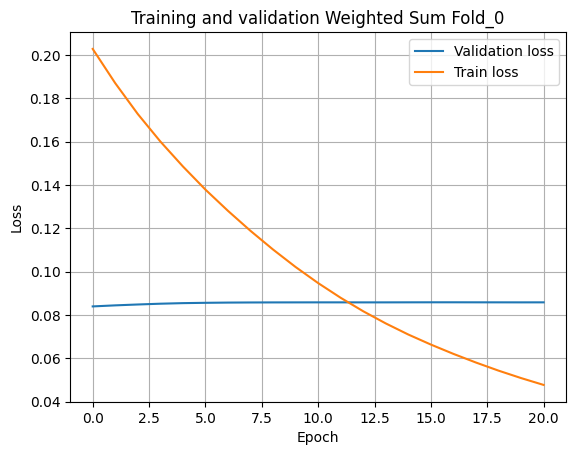

Número de salidas: 6


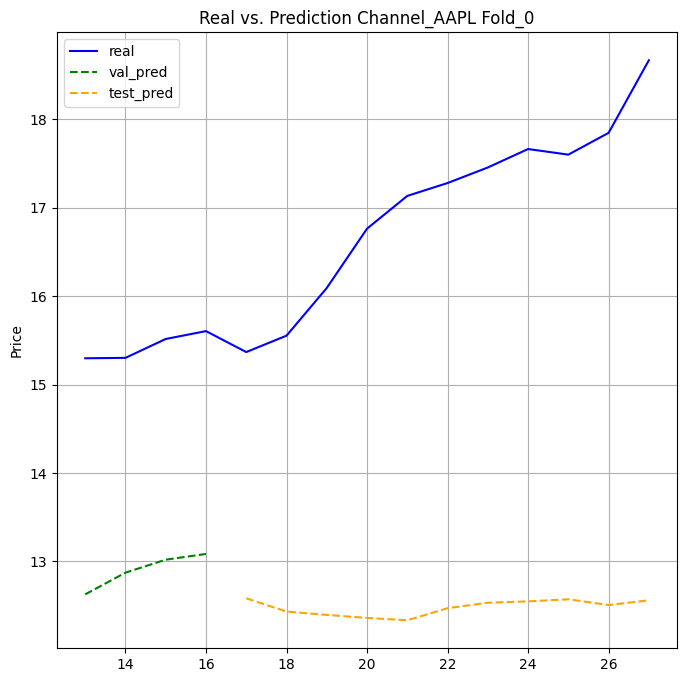

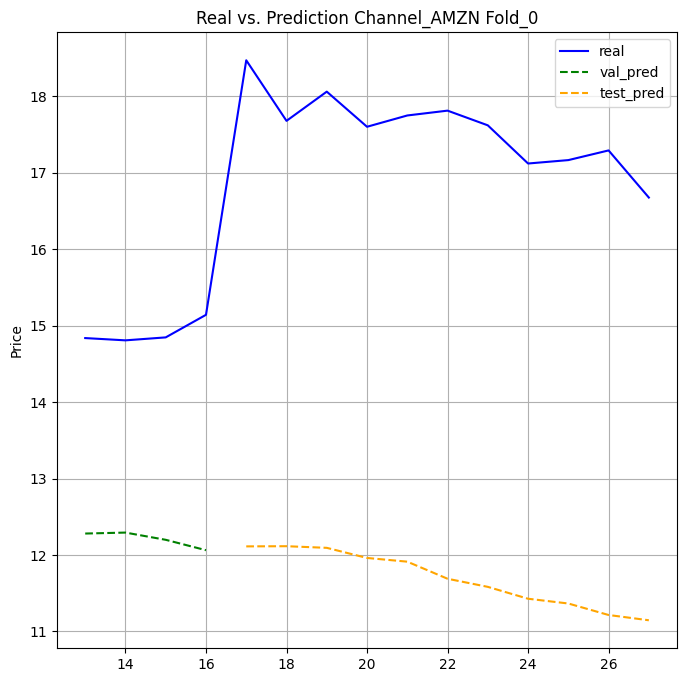

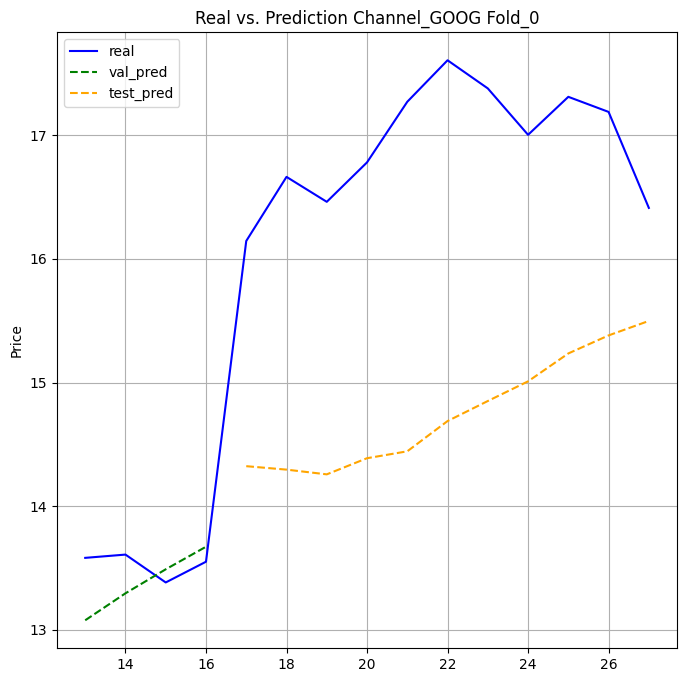

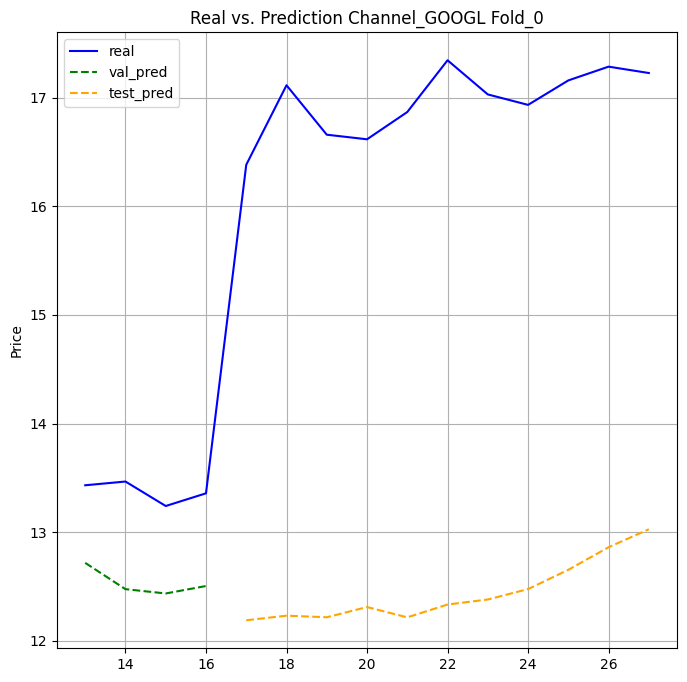

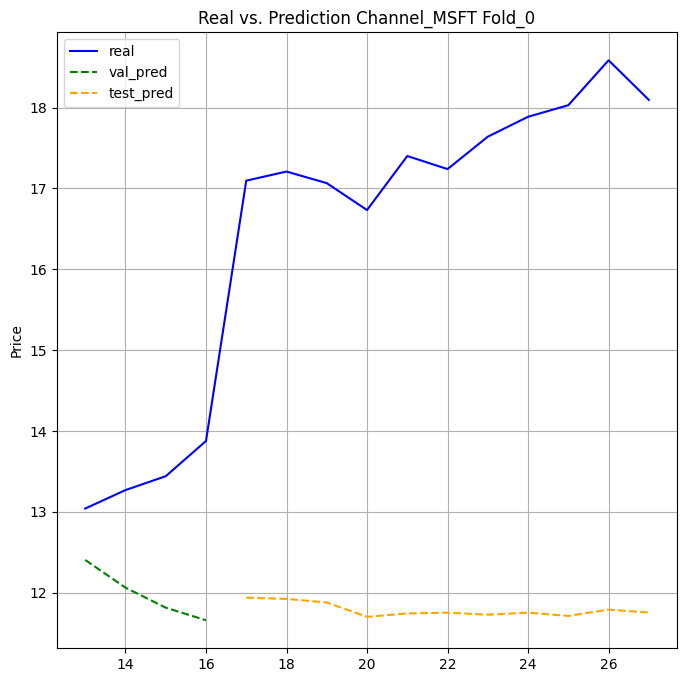

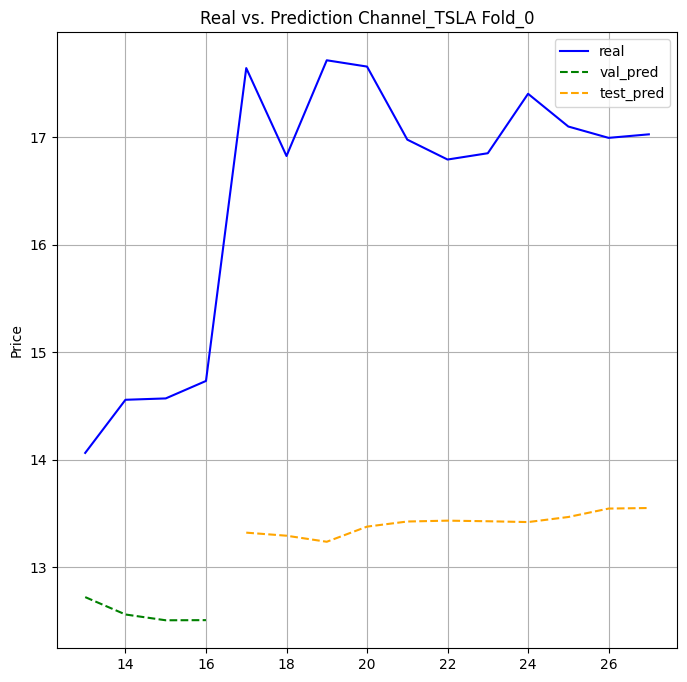

Fold_0 Done
Fold_1 Started...


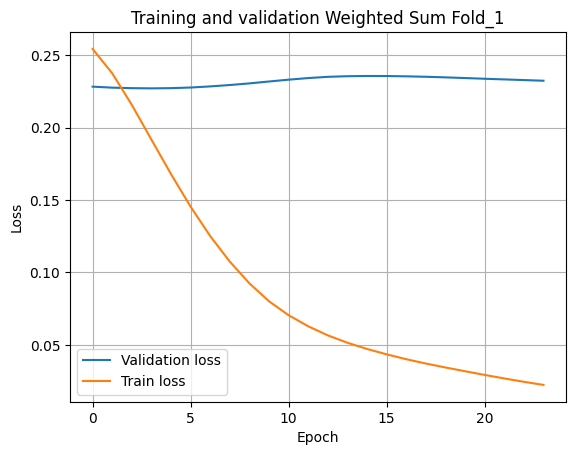

Número de salidas: 6


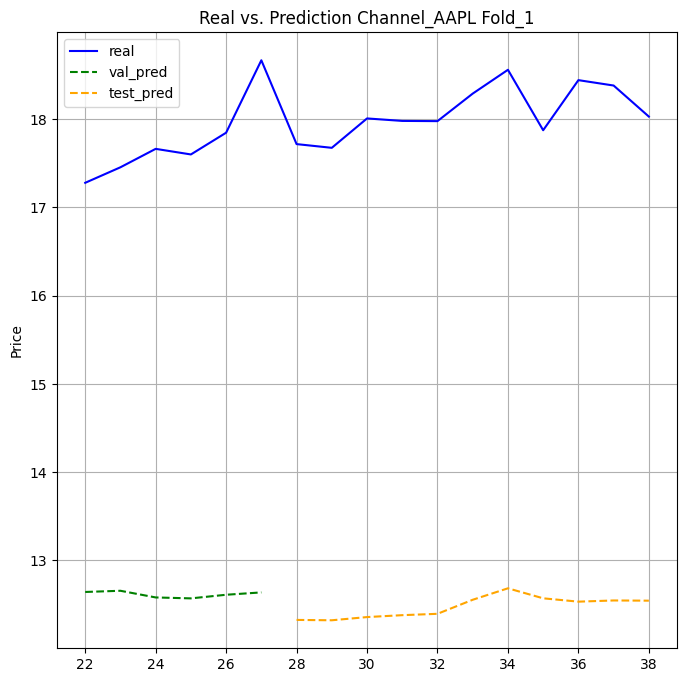

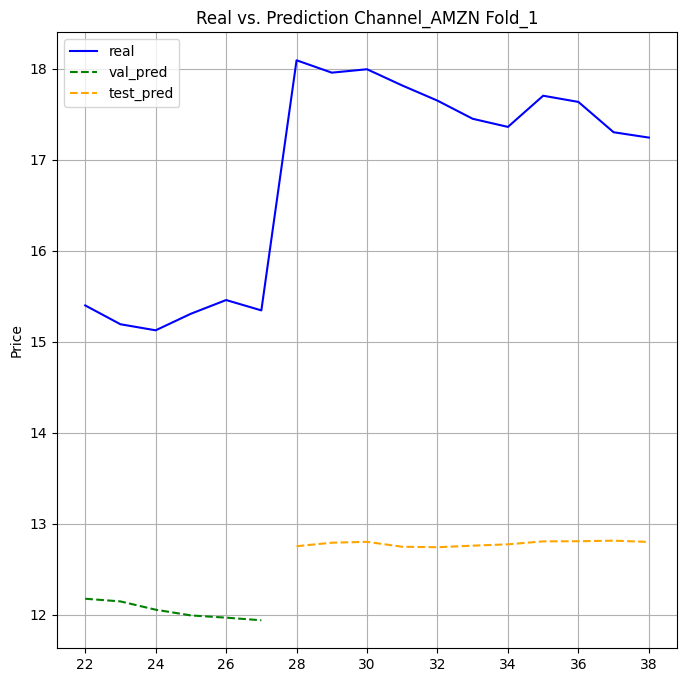

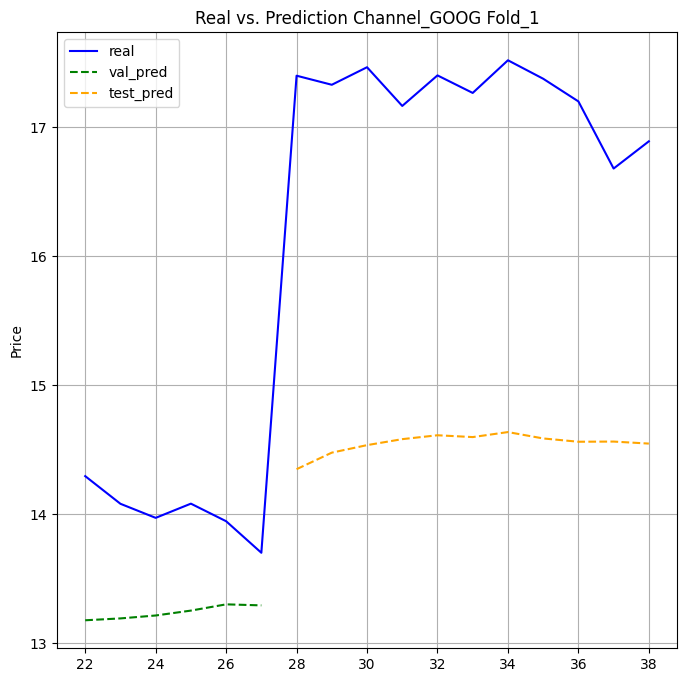

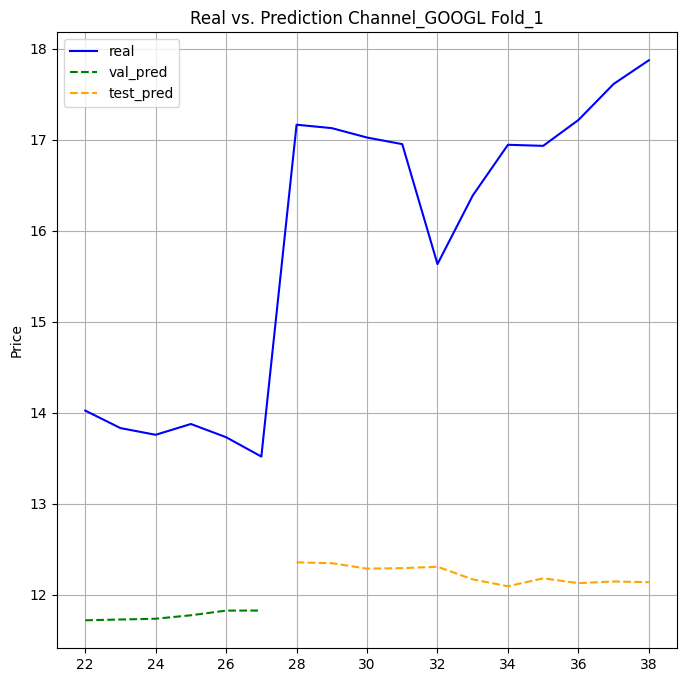

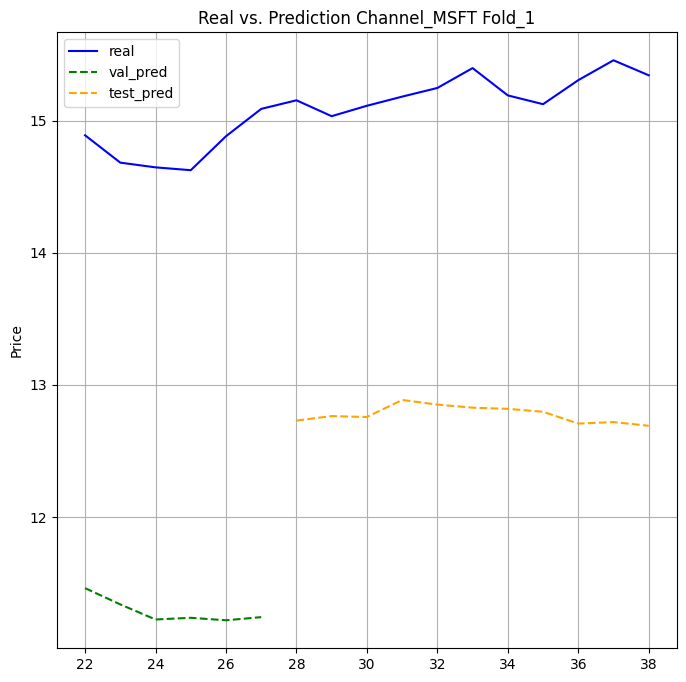

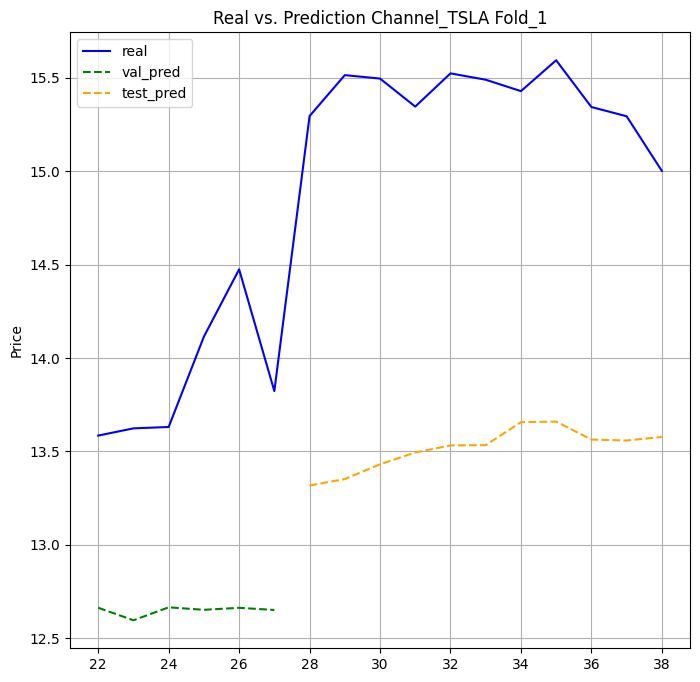

Fold_1 Done
Fold_2 Started...


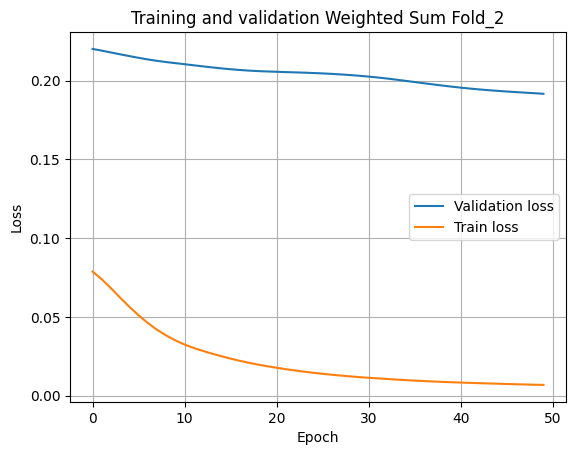

Número de salidas: 6


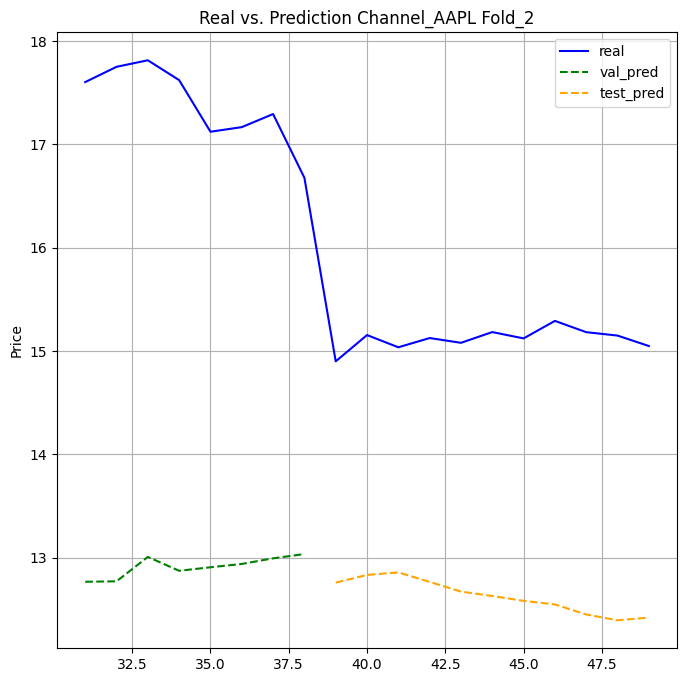

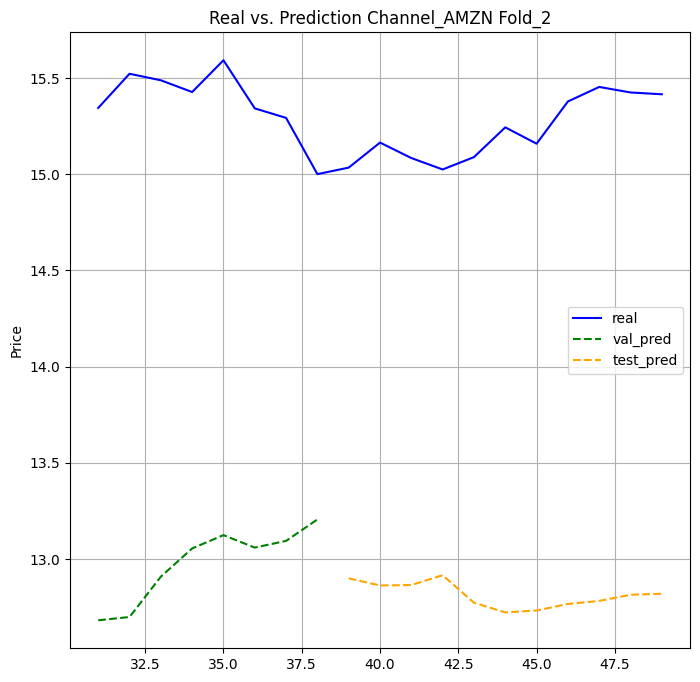

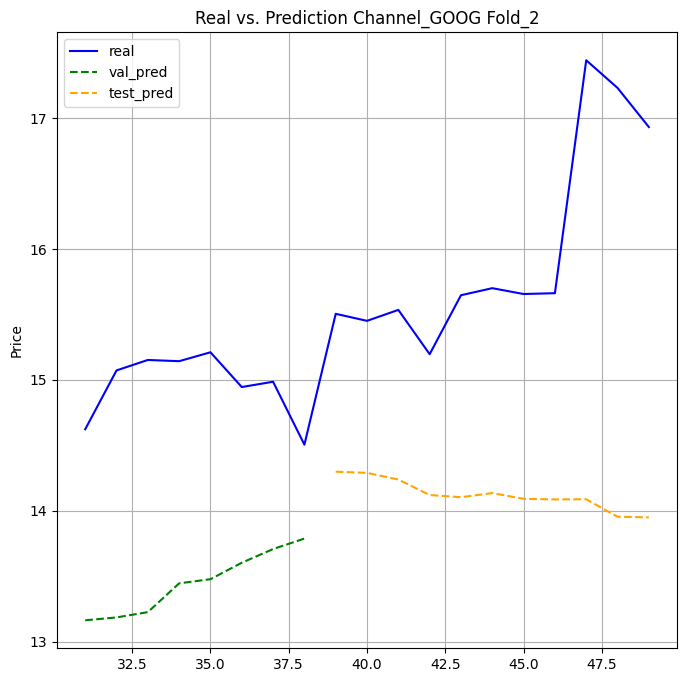

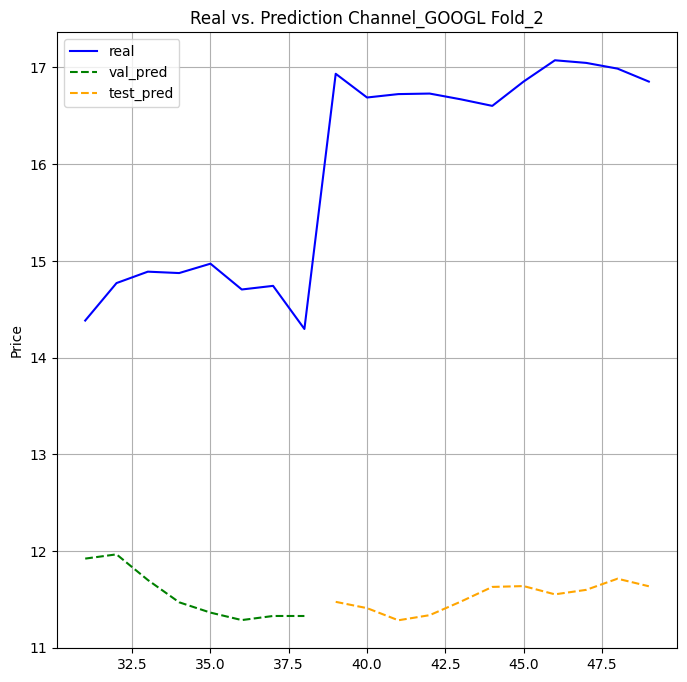

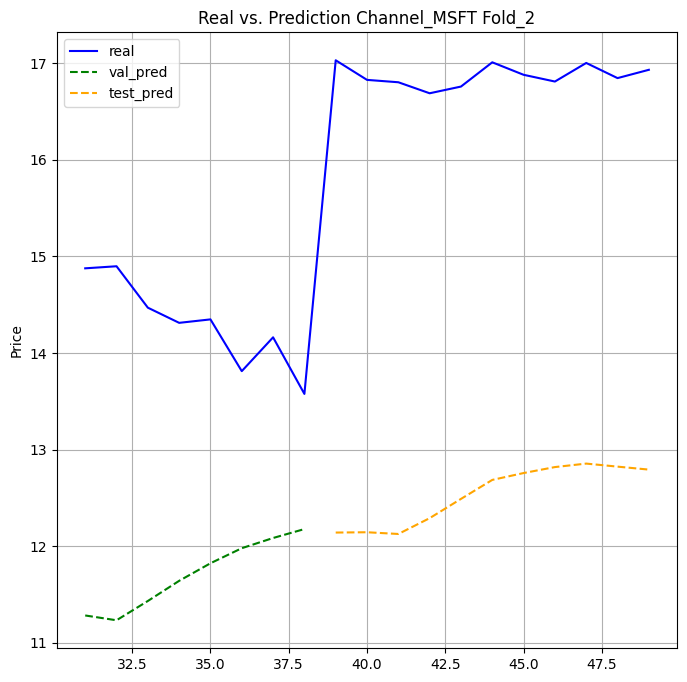

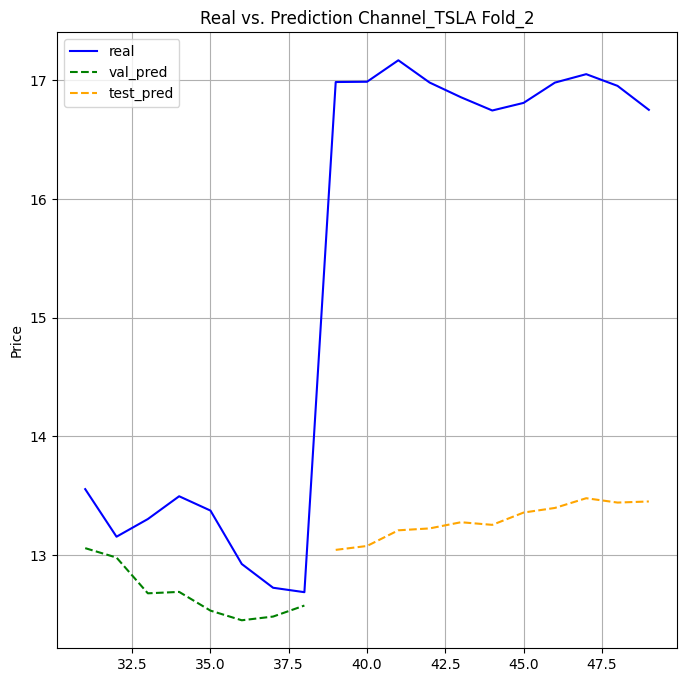

Fold_2 Done
Fold_3 Started...


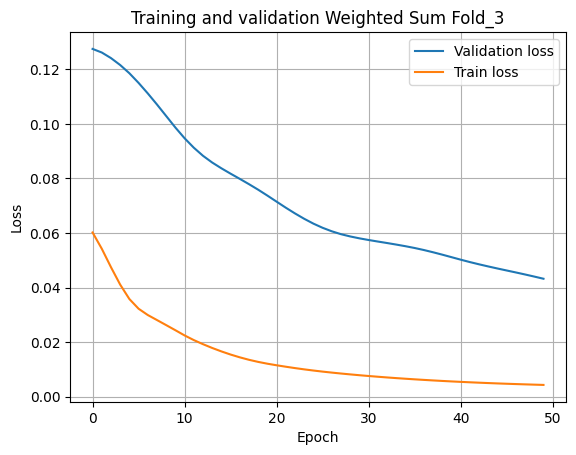

Número de salidas: 6


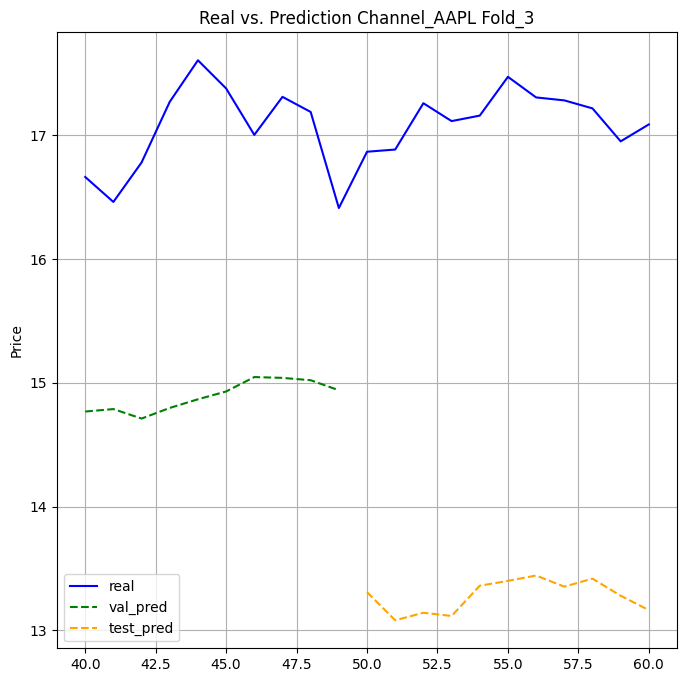

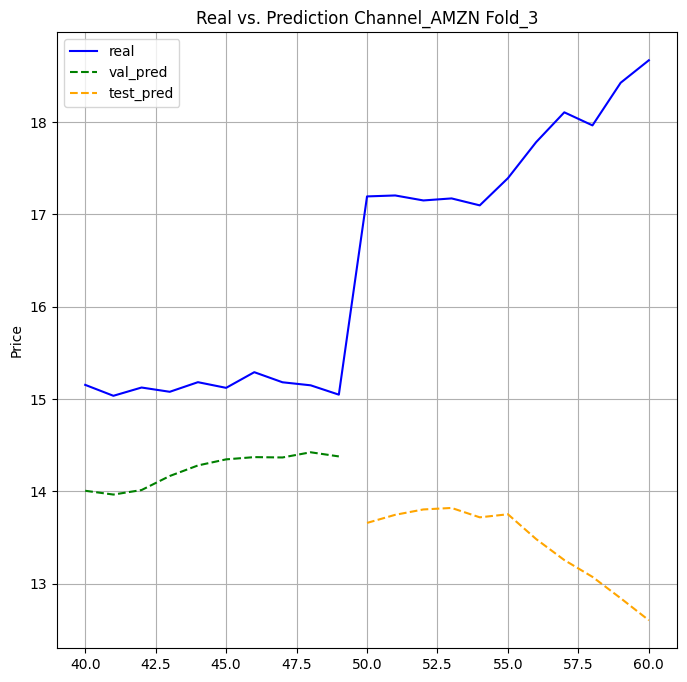

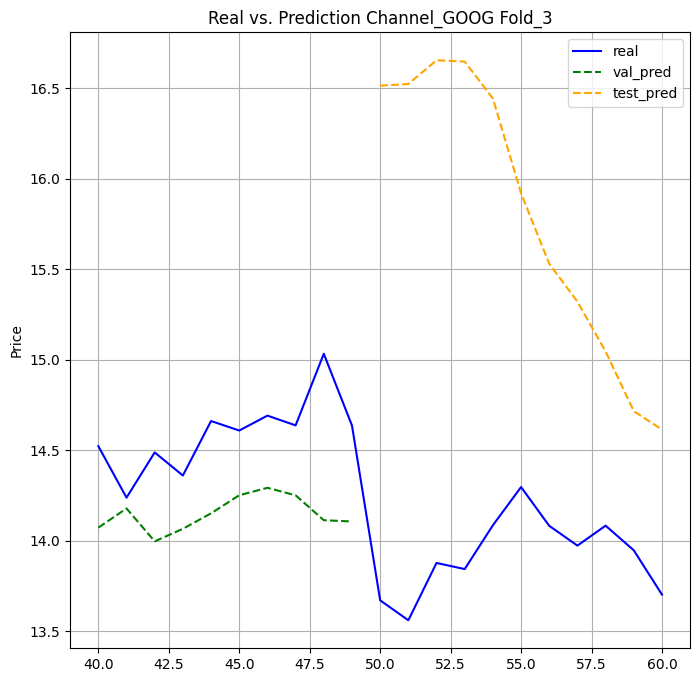

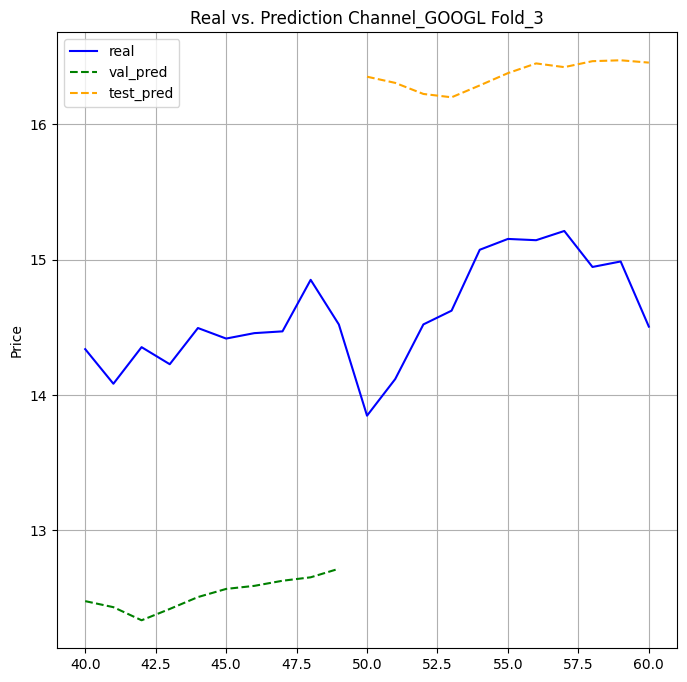

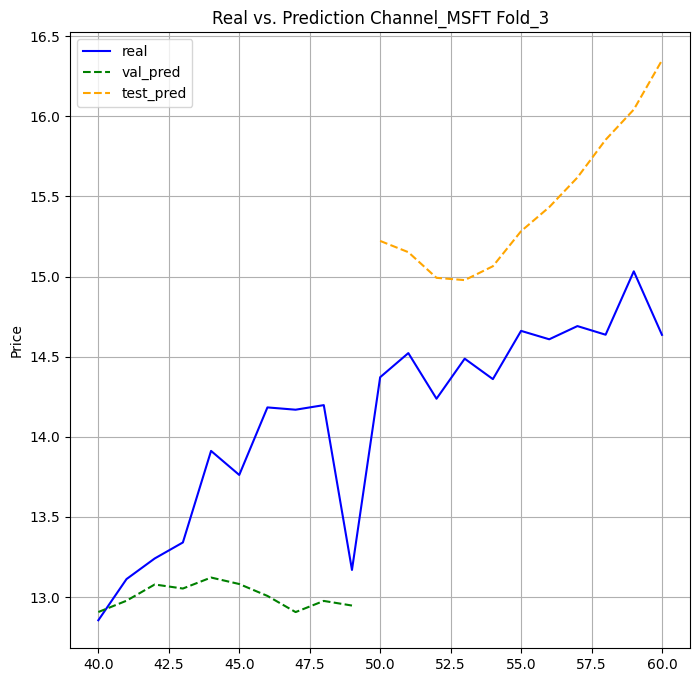

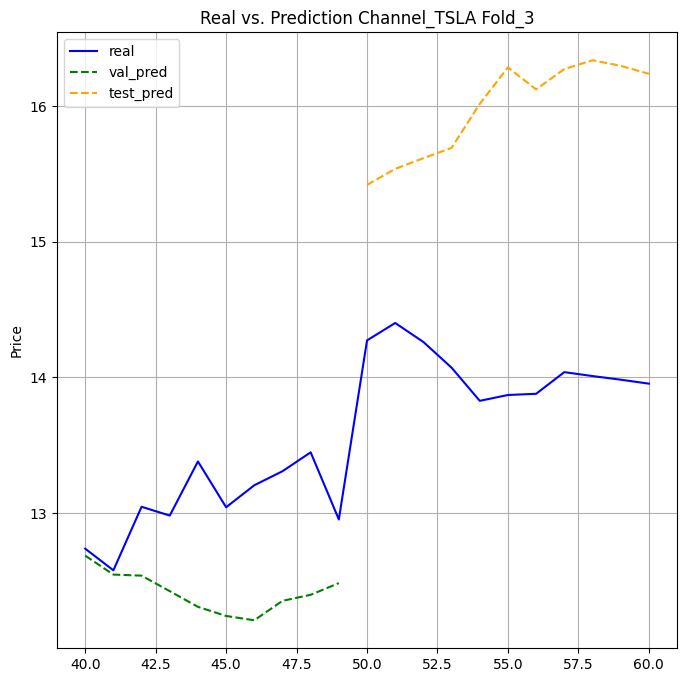

Fold_3 Done
Fold_4 Started...


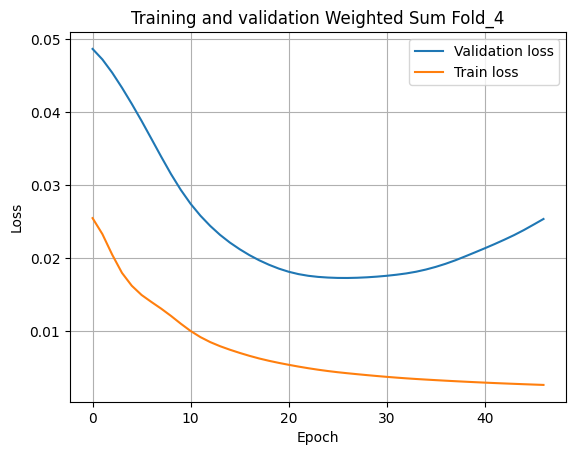

Número de salidas: 6


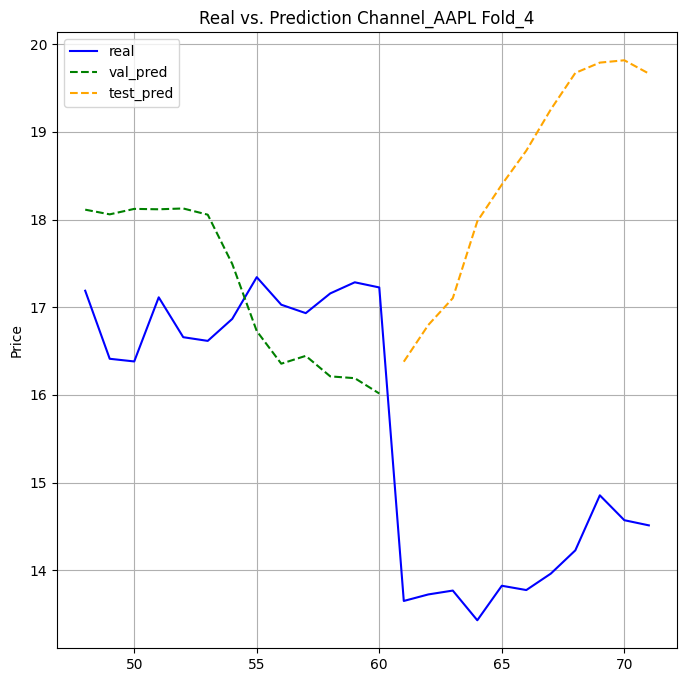

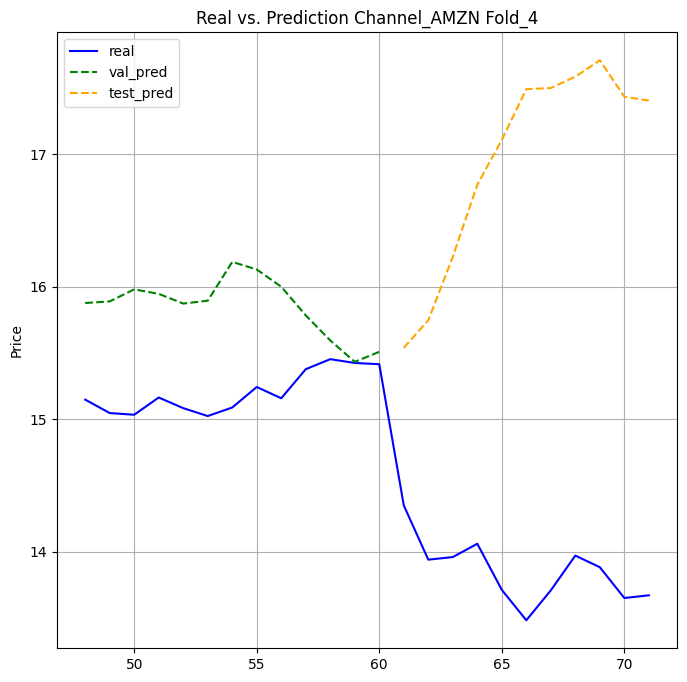

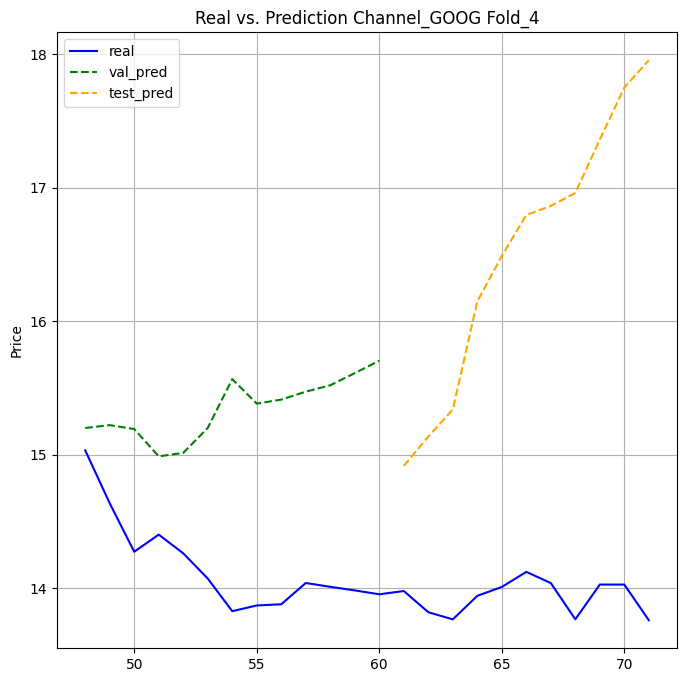

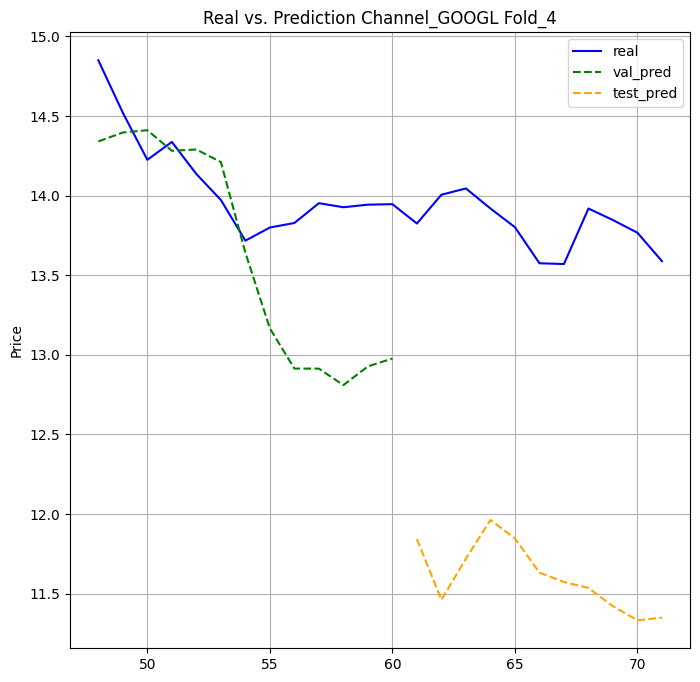

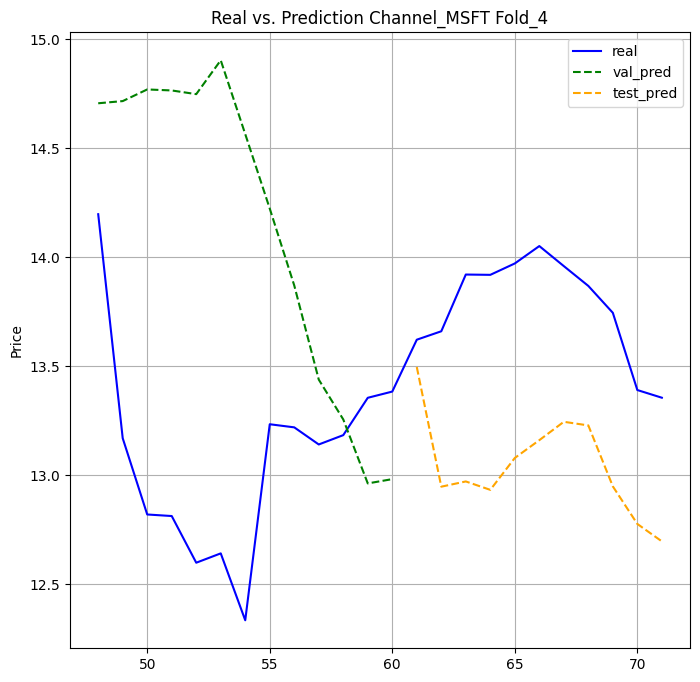

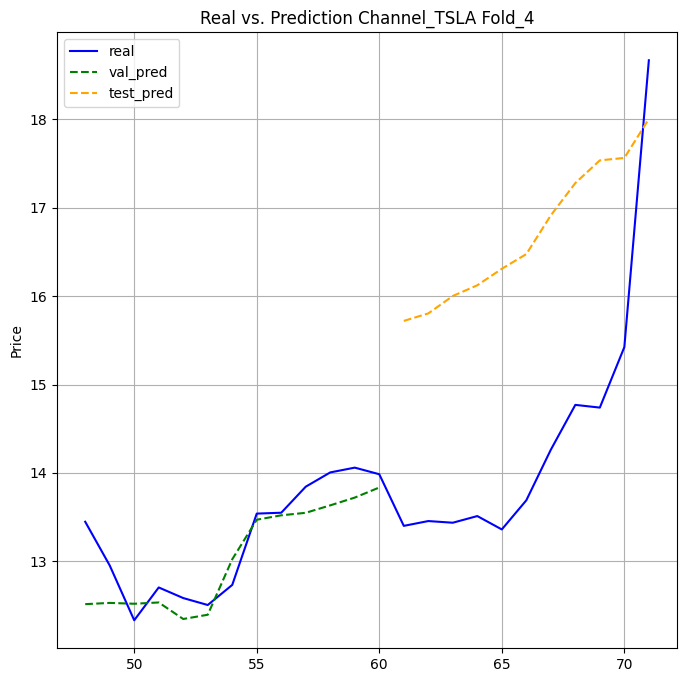

Fold_4 Done
Fold_5 Started...


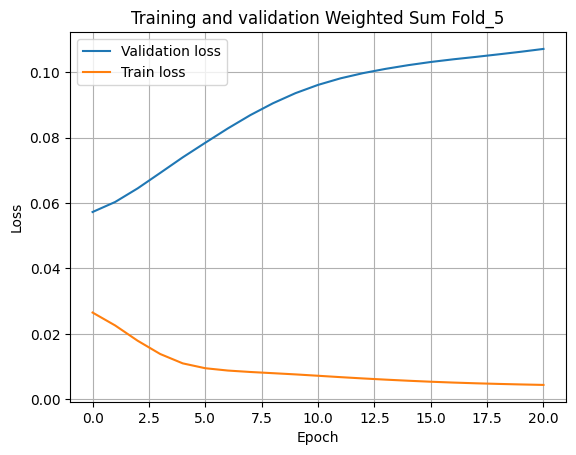

Número de salidas: 6


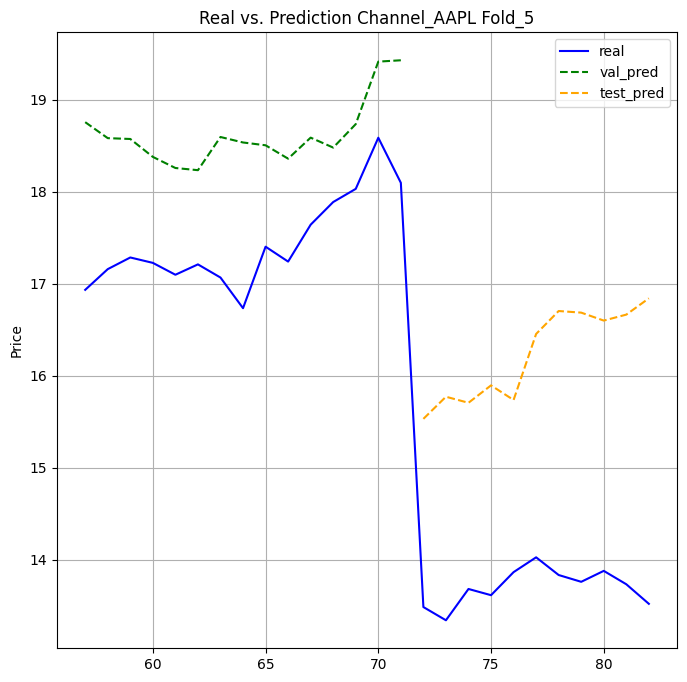

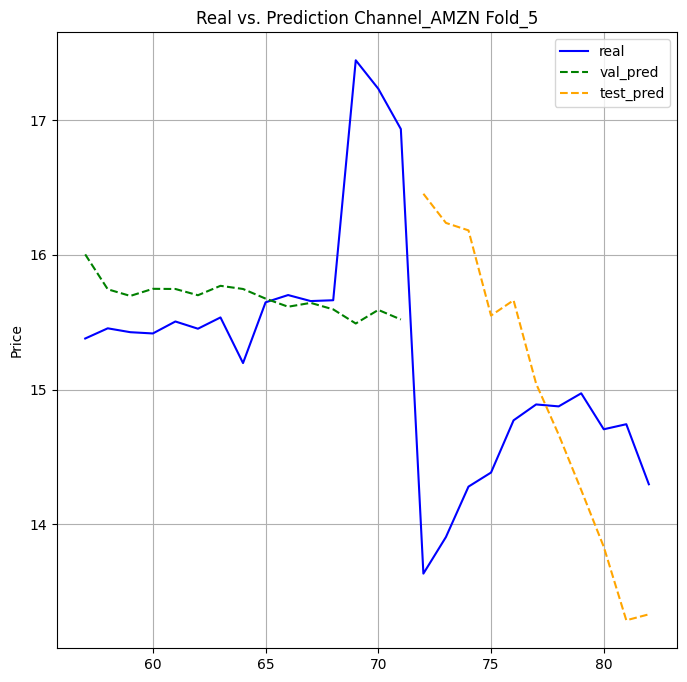

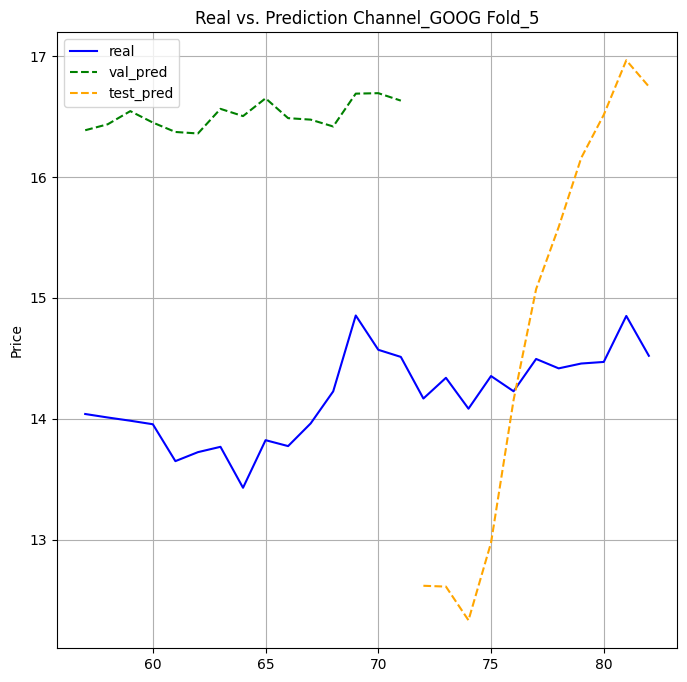

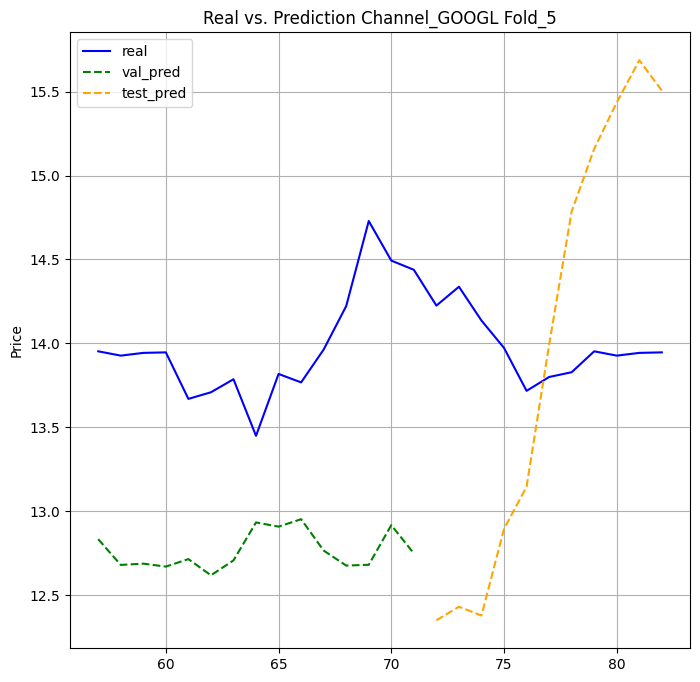

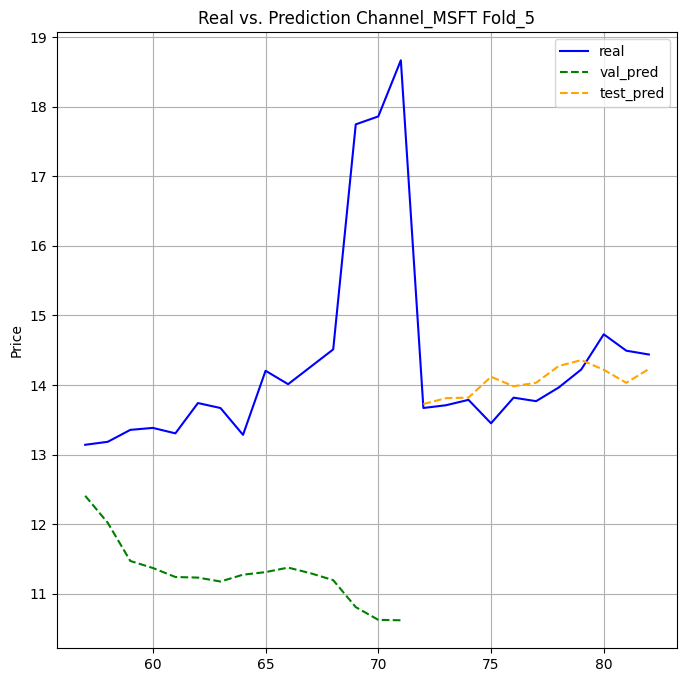

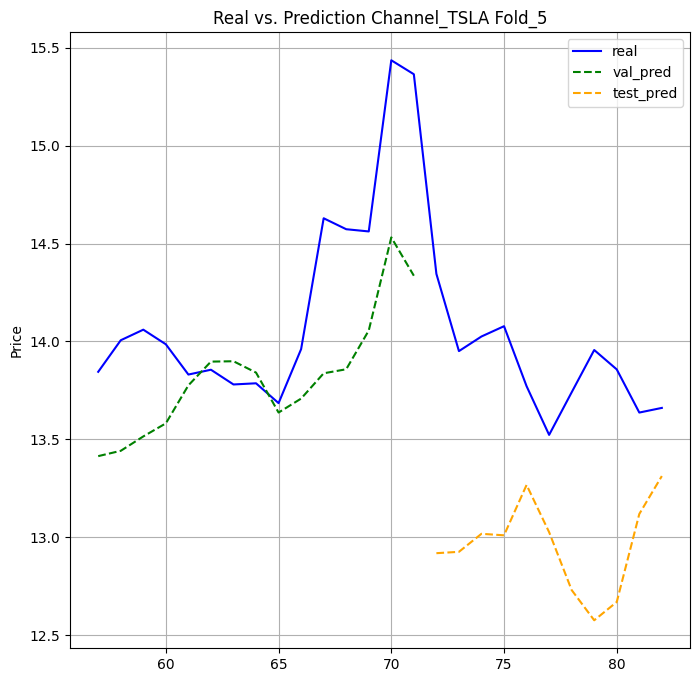

Fold_5 Done
Fold_6 Started...


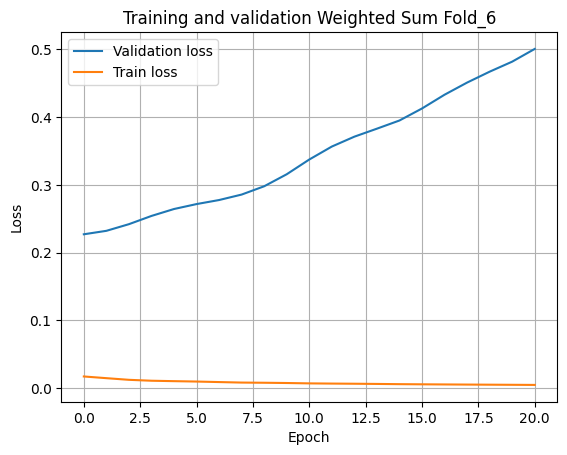

Número de salidas: 6


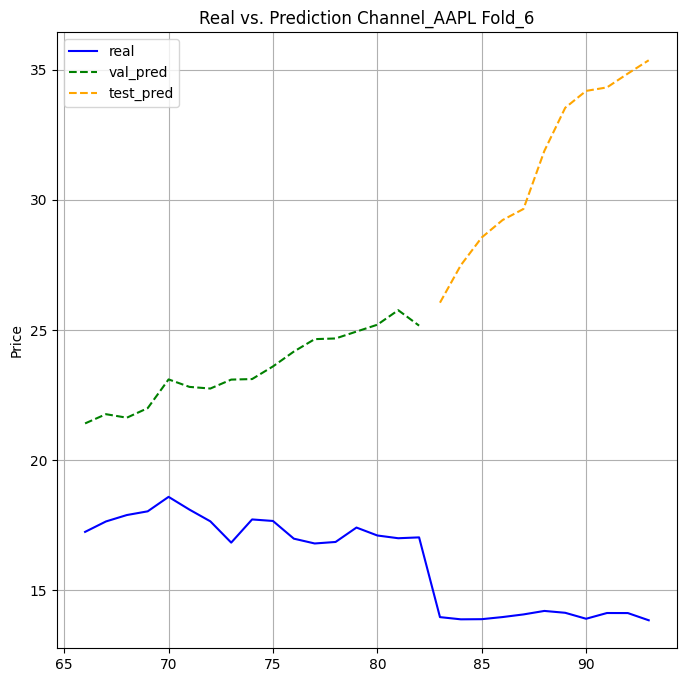

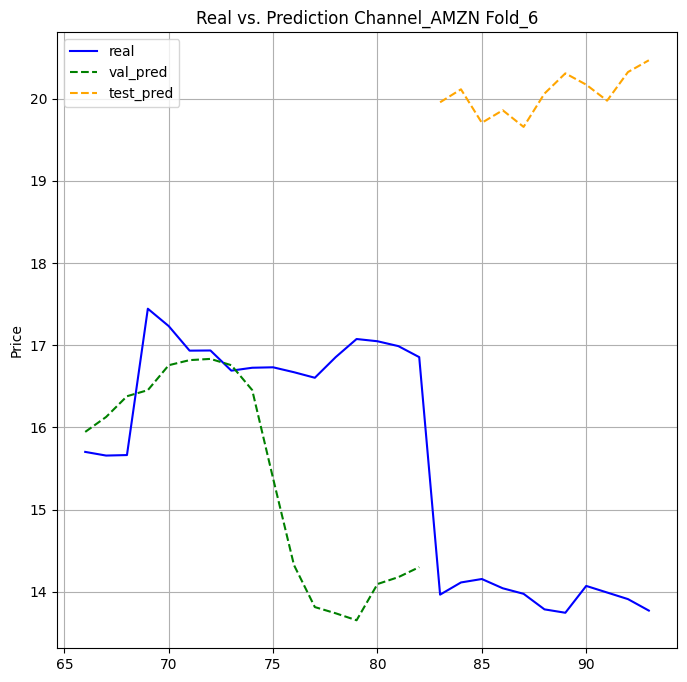

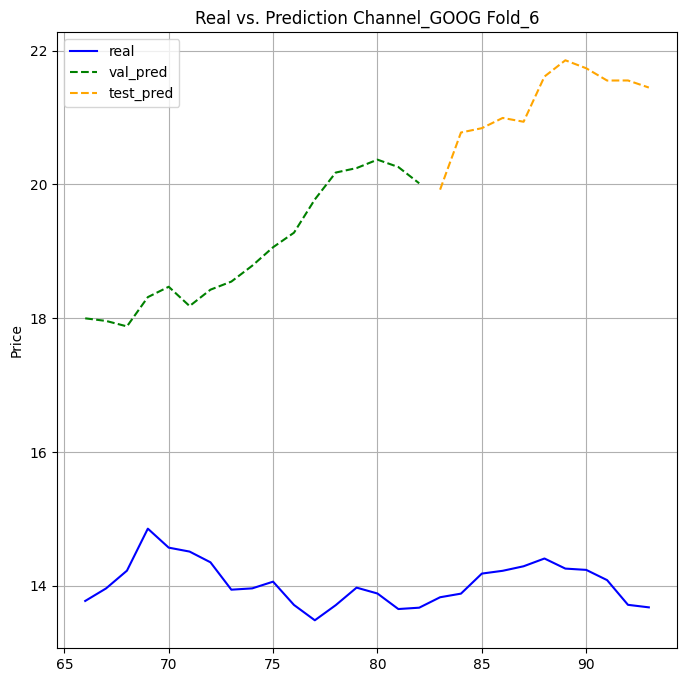

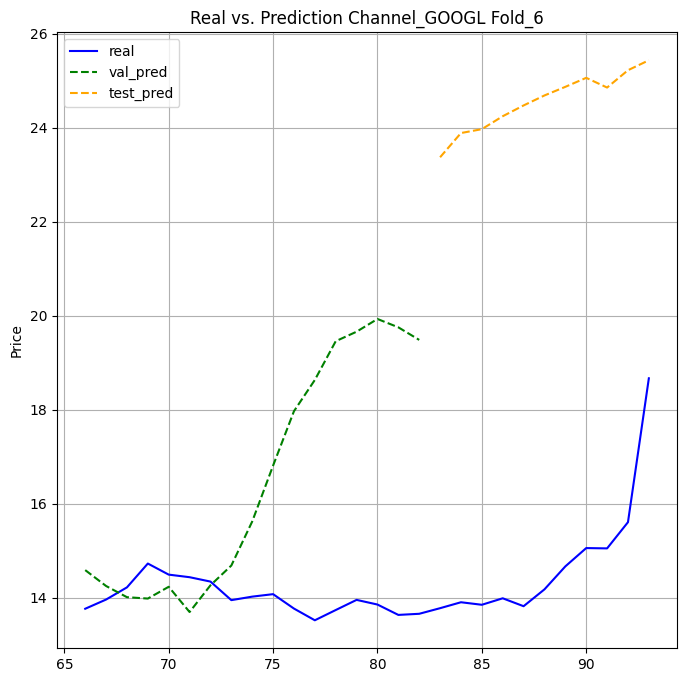

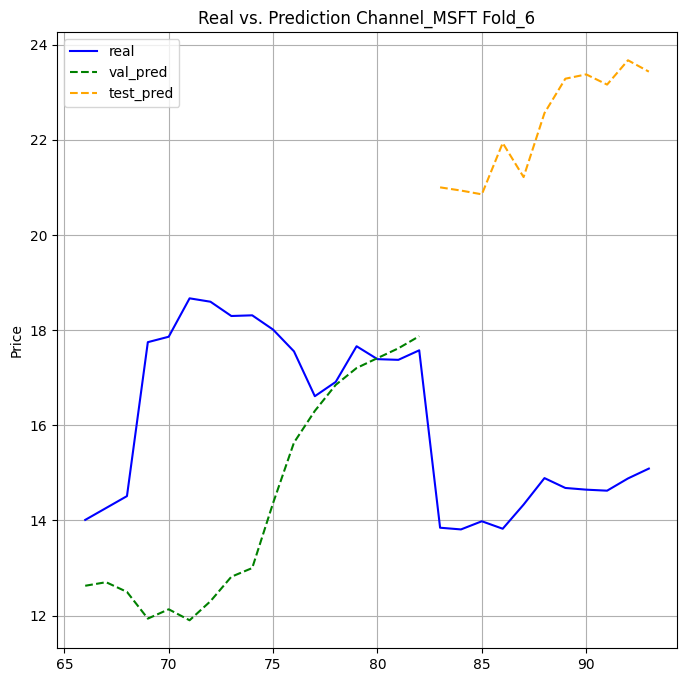

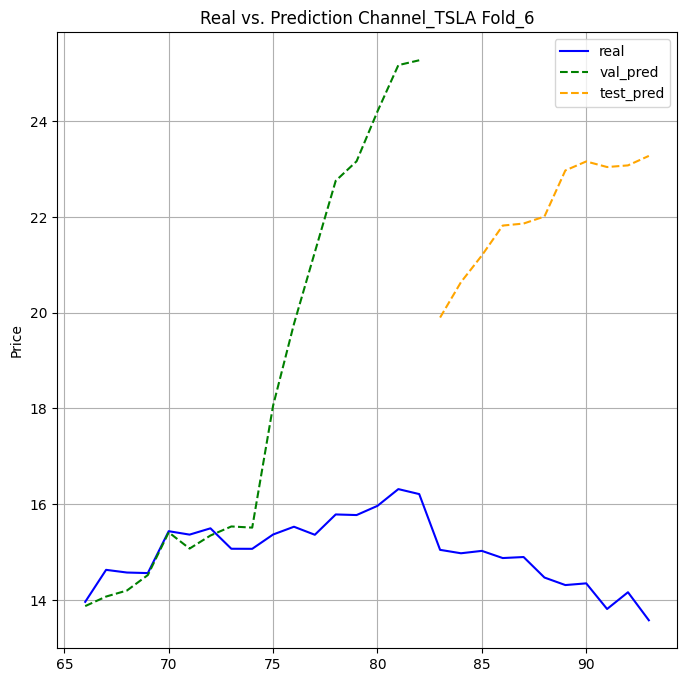

Fold_6 Done
Fold_7 Started...


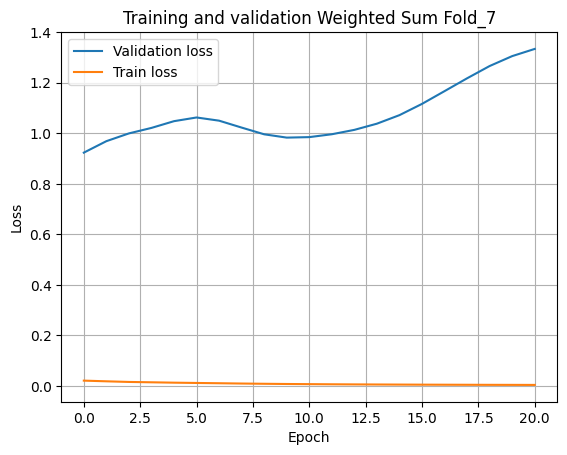

Número de salidas: 6


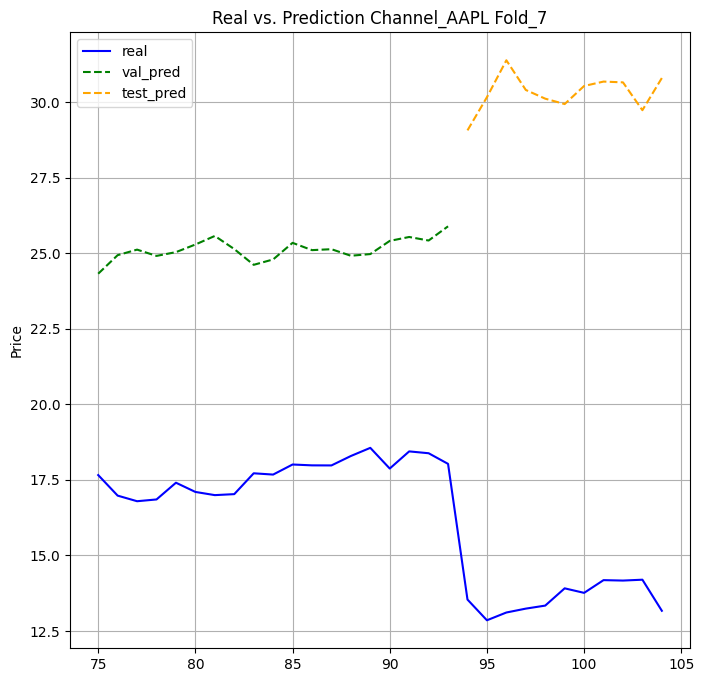

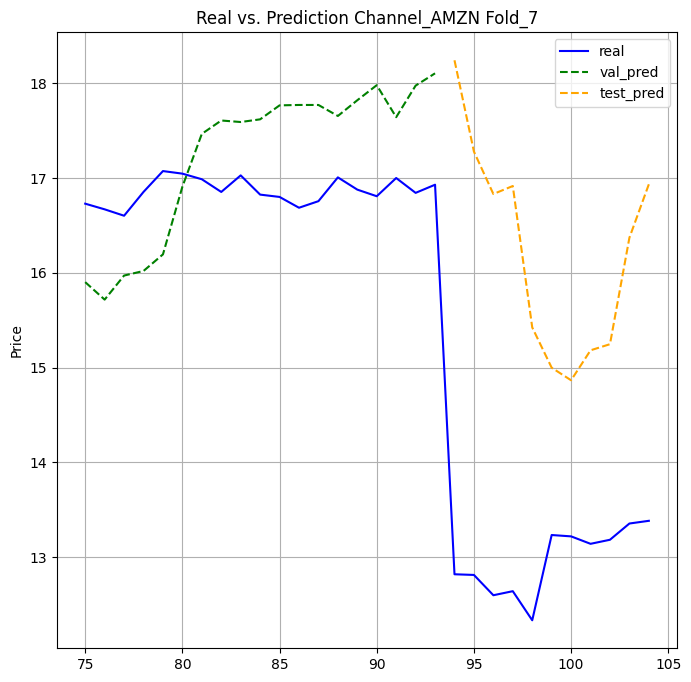

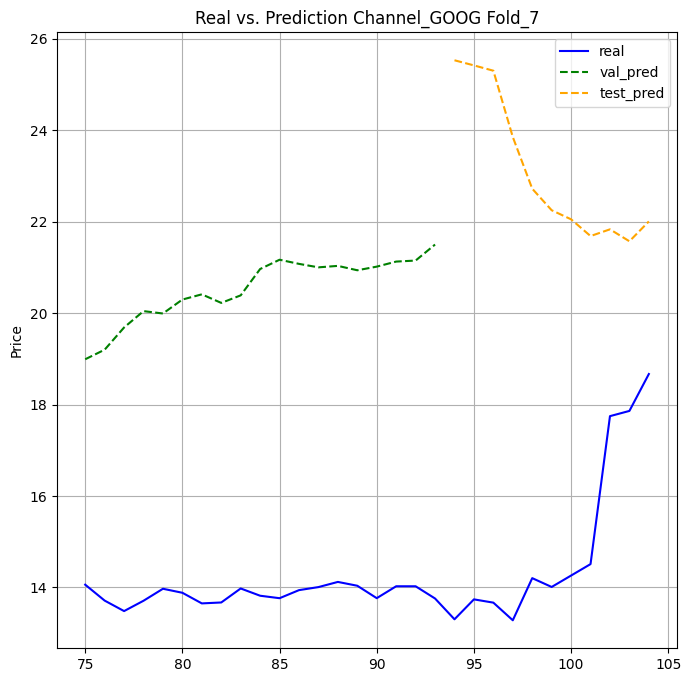

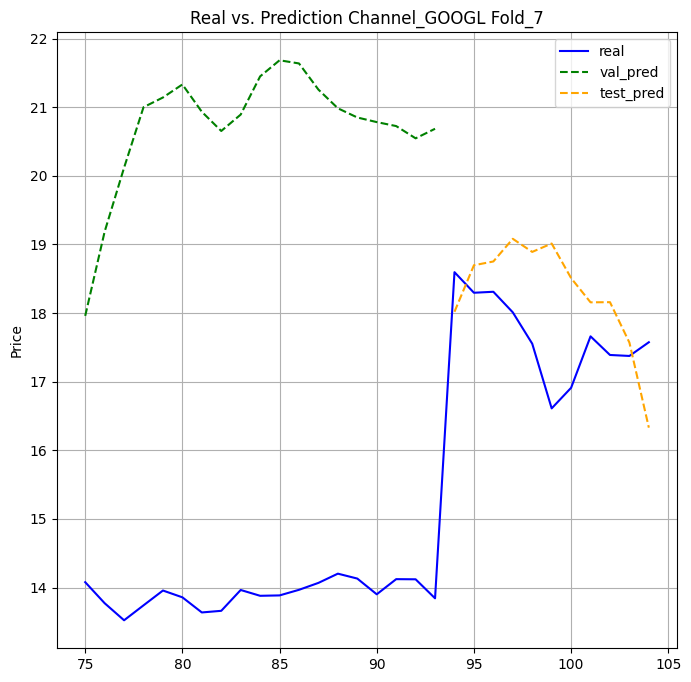

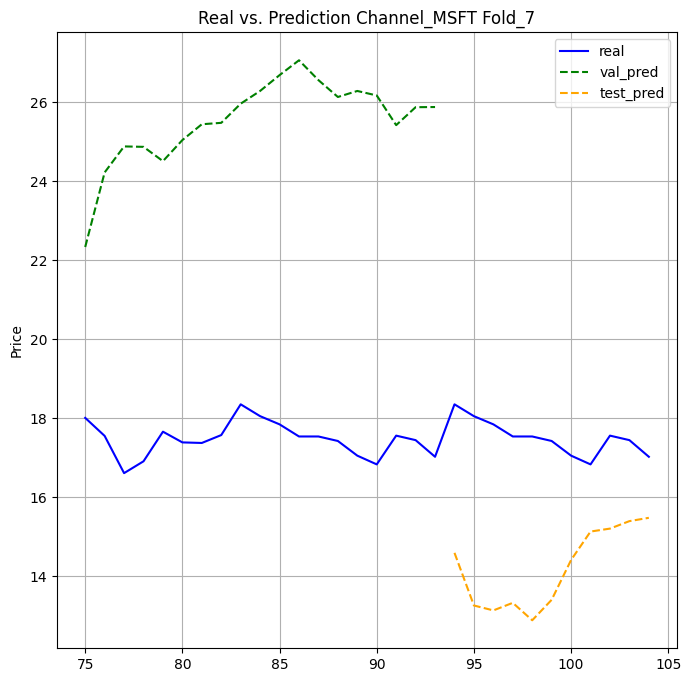

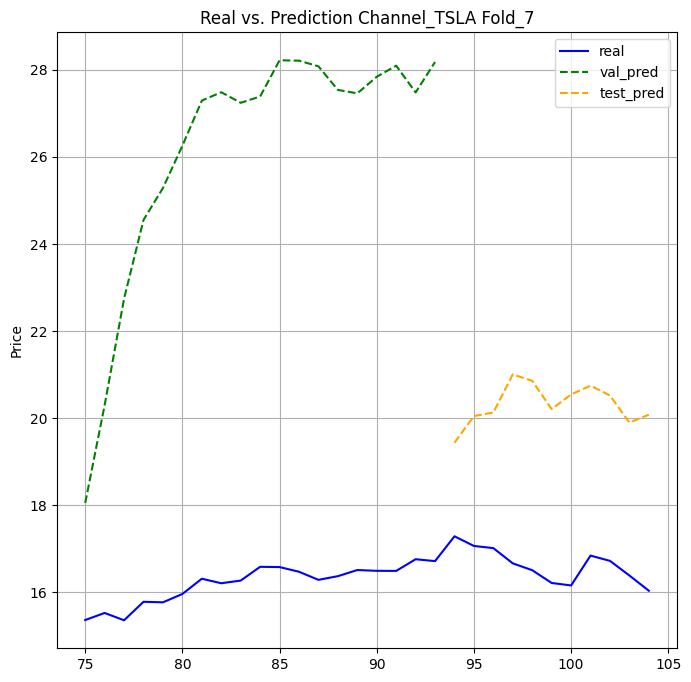

Fold_7 Done
Fold_8 Started...


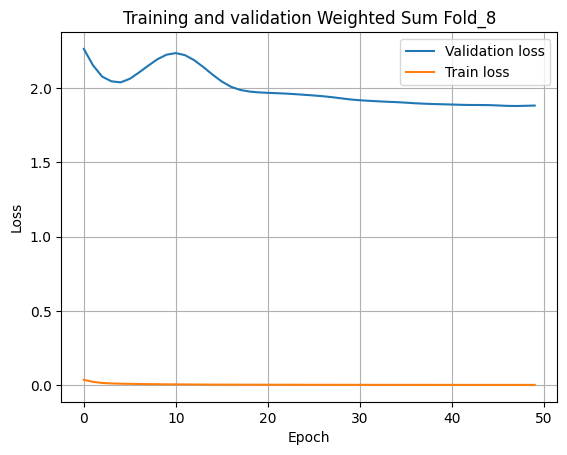

Número de salidas: 6


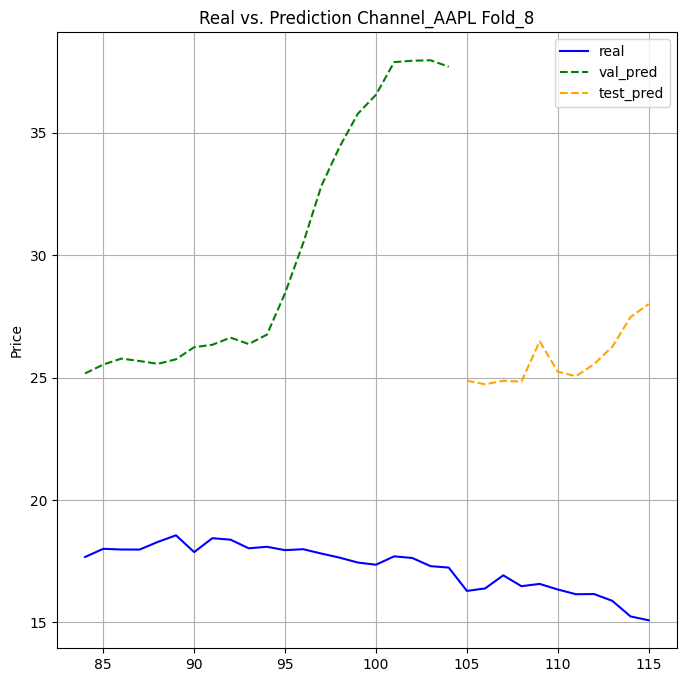

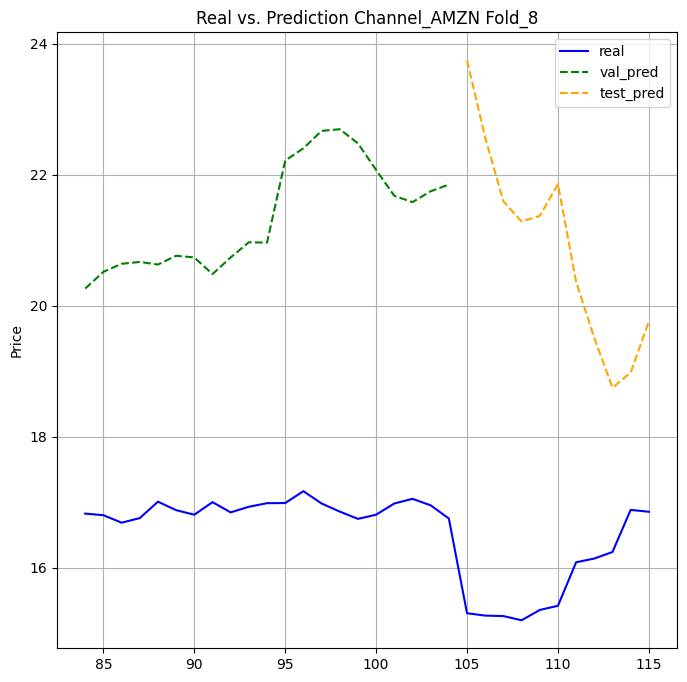

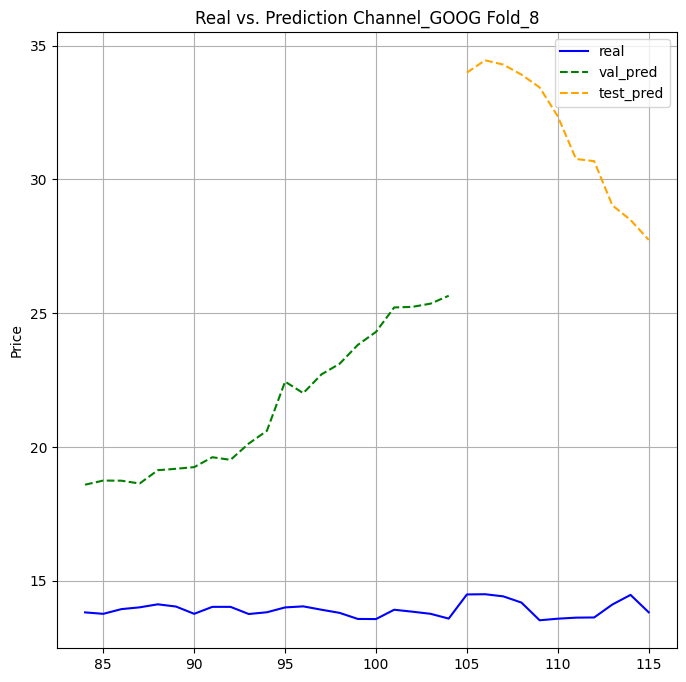

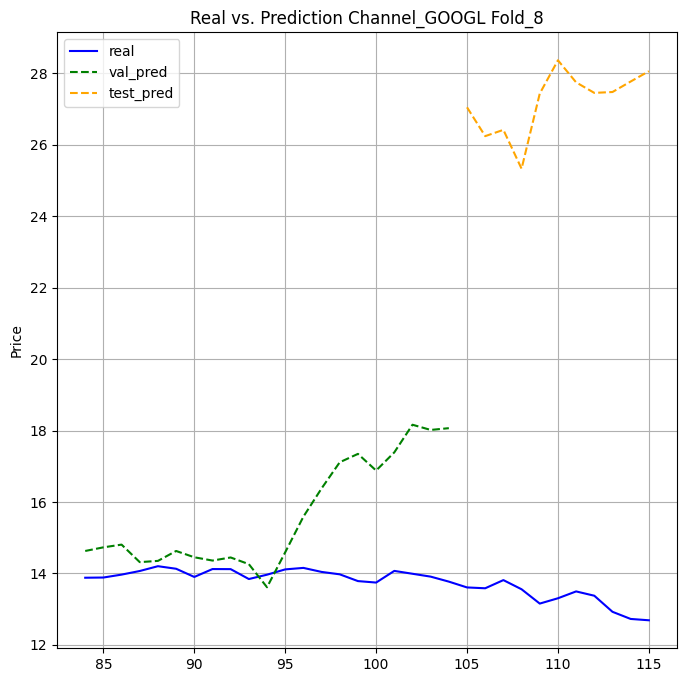

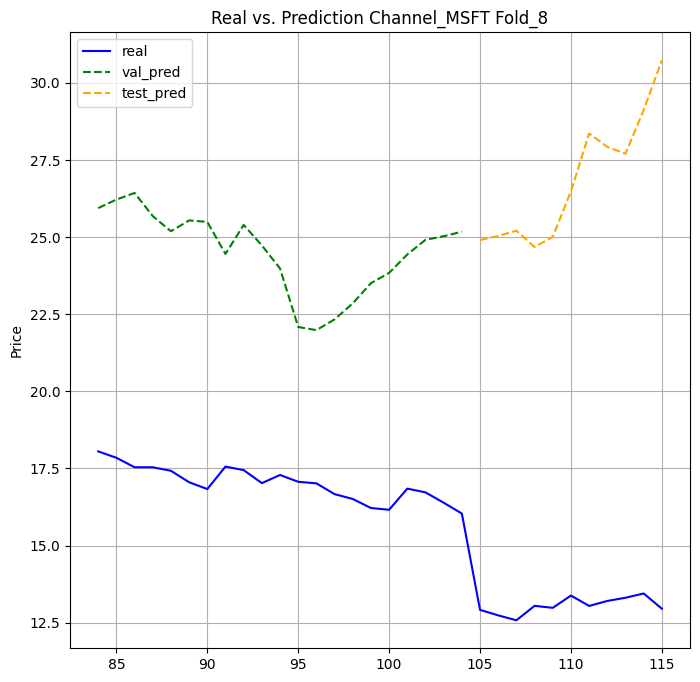

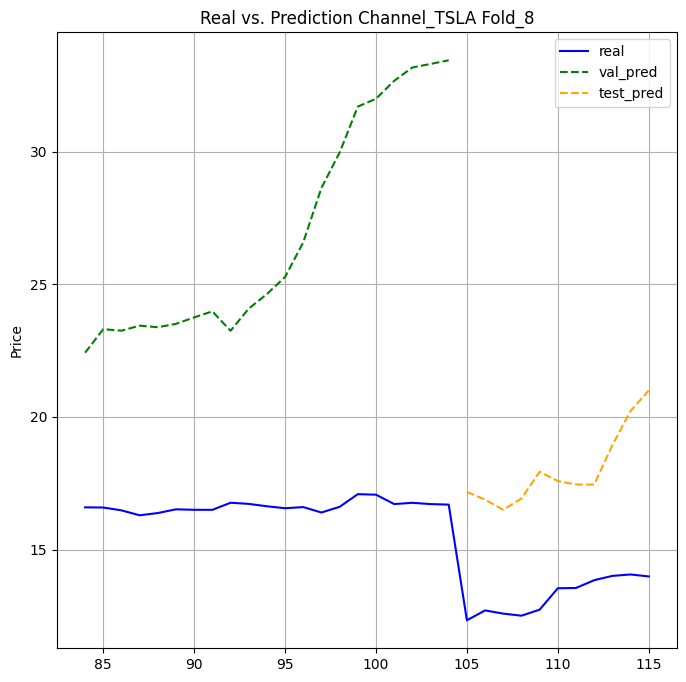

Fold_8 Done
Fold_9 Started...


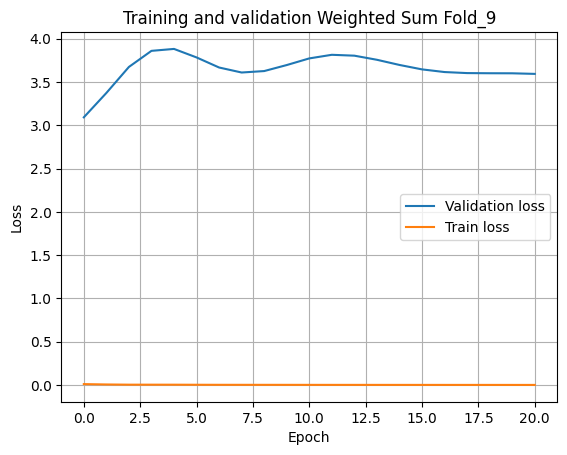

Número de salidas: 6


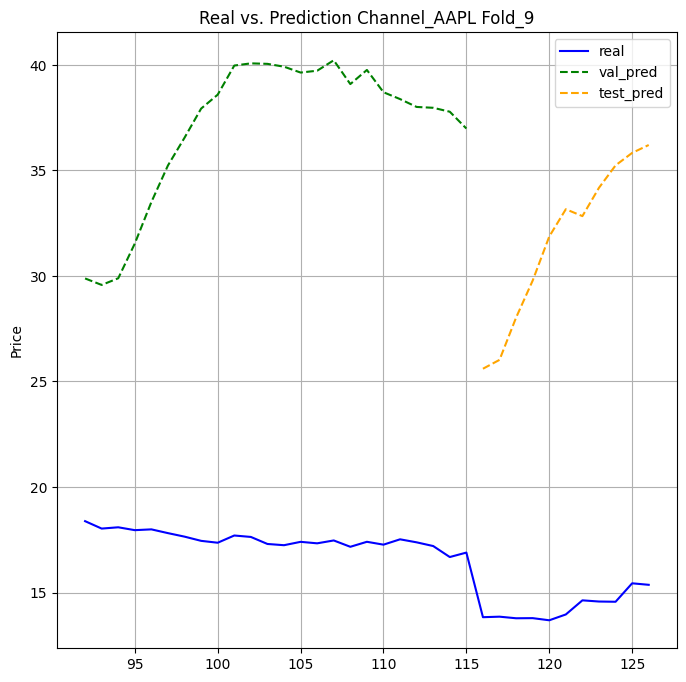

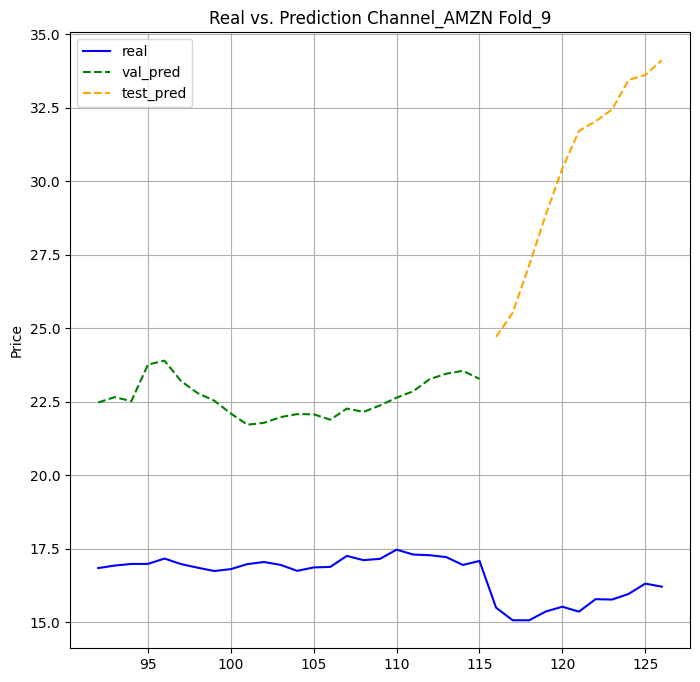

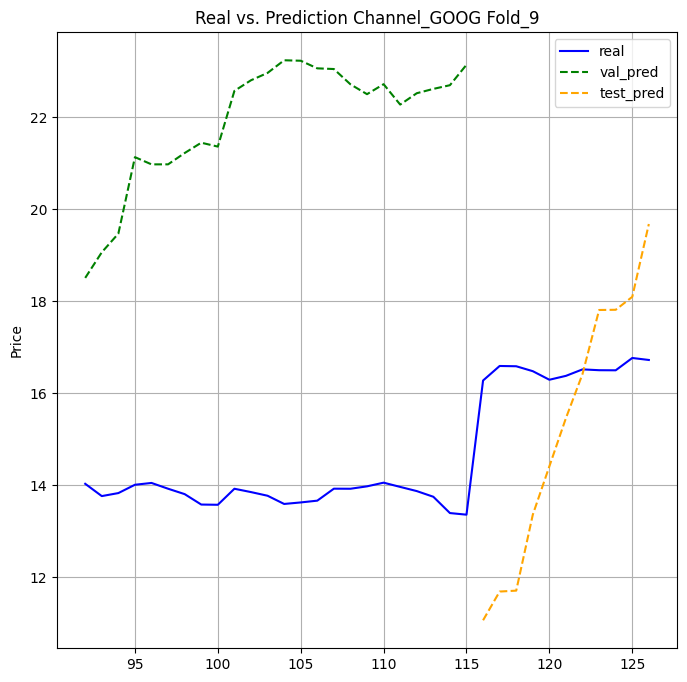

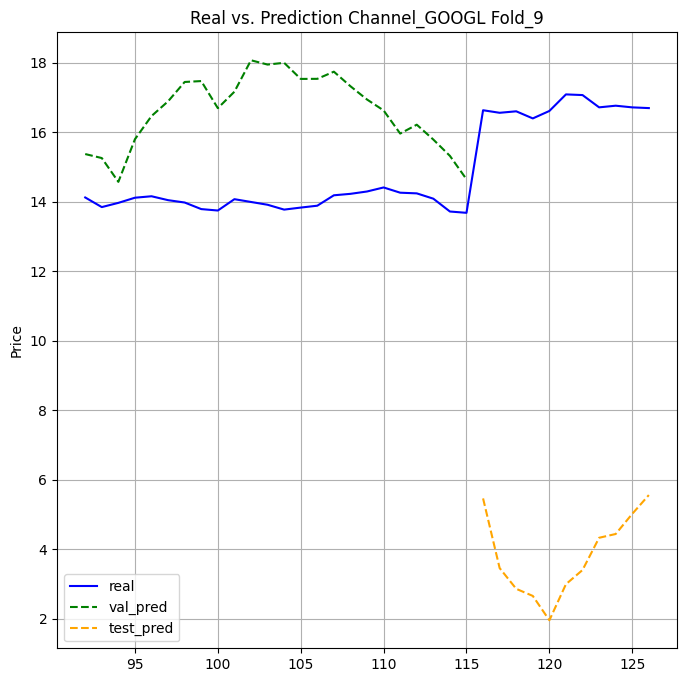

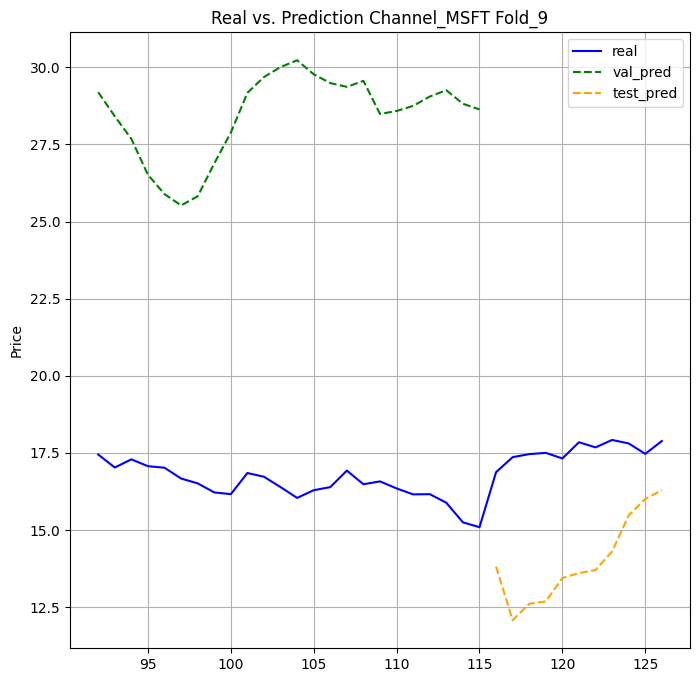

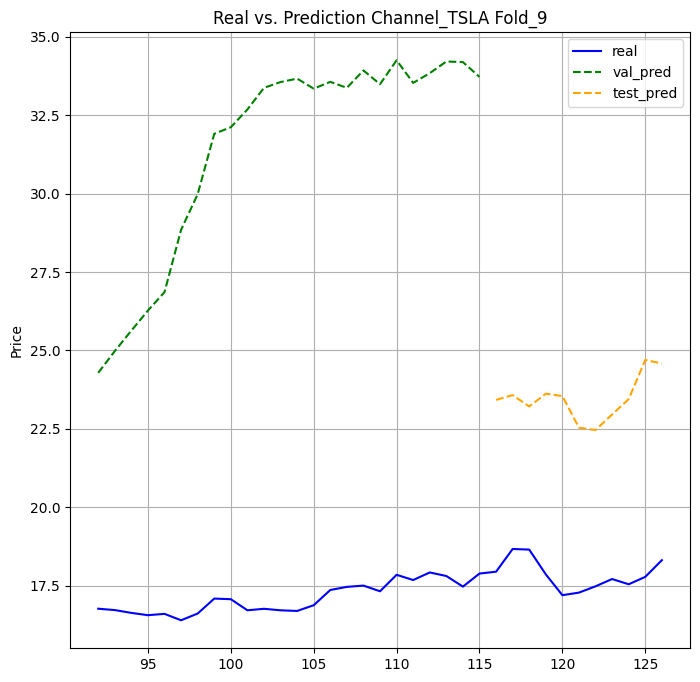

Fold_9 Done


In [85]:
val_losses=[]
train_losses=[]
history_ = []

model = tuner.hypermodel.build(best_hps)



# Reiniciar el índice de las capas en tu modelo
#model = reset_layers_index(model)
counter_fold =0
n_splits_CV=10

# Entrenar el modelo
for i in range(n_splits_CV):#cross val (10)
    Fold = 'Fold_' + str(counter_fold)
    counter_fold += 1
    print(f'{Fold} Started...')
    # Crear directorio para cada fold si no existe
    if not os.path.exists(os.path.join(dir, Fold)):
      os.makedirs(os.path.join(dir, Fold))

    history=model.fit(x_train_combined[i], y_train_combined[i], epochs=50, validation_data=(x_val_combined[i], y_val_combined[i]), shuffle=False, callbacks=[early_stop], verbose=False)
    history_.append(history)
    val_losses.append(history.history['val_loss'])
    train_losses.append(history.history['loss'])

    plt.plot(history.history['val_loss'], label=f'Validation loss')
    plt.plot(history.history['loss'],  label=f'Train loss')

    plt.title(f'Training and validation Weighted Sum Fold_{i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(dir,Fold,f'training_validation_weighted_sum_fold{i}.png'))
    plt.show()
    plt.close()

    y_test1 = []
    for ytc in y_testA_[i]:
      y_test_channel = np.repeat(ytc, X_channels[0].shape[2], axis=1)
      y_test_channel_ = scaler.inverse_transform(y_test_channel)[:, -1]
      y_test1.append(y_test_channel_)

    # Ajuste de y_val
    y_val1 = []
    for yvc in y_val_[i]:
      y_val_channel = np.repeat(yvc, X_channels[0].shape[2], axis=1)
      y_val_channel_ = scaler.inverse_transform(y_val_channel)[:, -1]
      y_val1.append(y_val_channel_)

     # Predicción para y_val, y_pred
    y_val_pred = []
    y_pred = []
    y_val_pred_normal=[]
    y_pred_normal=[]
    y_val_pred.append(model.predict(x_val_combined[i], verbose=False))
    y_pred.append(model.predict(x_testA_combined[i], verbose=False))

    output_shape = model.layers[-1].output_shape
    num_outputs = output_shape[-1]

    print(f"Número de salidas: {num_outputs}")

    num_channels = 6
    # Crear una lista para almacenar las predicciones separadas por canal
    y_val_pred_per_channel = []
    # Iterar sobre las muestras en las predicciones secuenciales
    for sample in y_val_pred:
        # Dividir la muestra en partes correspondientes a cada canal
        y_val_pred_per_channel.append(np.split(sample, num_channels, axis=1))
    #print('y_val_predictions_per_channel ',y_val_pred_per_channel)

    # Crear una lista para almacenar las predicciones separadas por canal
    y_pred_per_channel = []
    # Iterar sobre las muestras en las predicciones secuenciales
    for sample in y_pred:
        # Dividir la muestra en partes correspondientes a cada canal
        y_pred_per_channel.append(np.split(sample, num_channels, axis=1))
    #print('y_predictions_per_channel ',y_pred_per_channel)

    # for i in range(len(y_val_pred)):
    #   print(f"Predicción {i}: {y_pred[i]}")

    for xvc in y_val_pred_per_channel[0]:
      #xc = xvc[:, 0, :]
      y_val_pred_channel = np.repeat(xvc, X_channels[0].shape[2], axis=1)
      #desconcatenar, pribar!
      y_val_pred_channel_ =scaler.inverse_transform(y_val_pred_channel)[:, -1]
      y_val_pred_normal.append(y_val_pred_channel_)


    for ypc in y_pred_per_channel[0]:
      #yc = ypc[:, 0, :]
      y_pred_channel = np.repeat(ypc, X_channels[0].shape[2], axis=1)
      y_pred_channel_ = scaler.inverse_transform(y_pred_channel)[:, -1]
      y_pred_normal.append(y_pred_channel_)


    for k in range(len(y_test1)):
      # Cálculo de métricas
      t_mse = mse(y_pred_normal[k], y_test1[k])
      t_mses.append(t_mse)
      v_mse = mse(y_val_pred_normal[k], y_val1[k])
      v_mses.append(v_mse)

      t_mae = mae(y_pred_normal[k], y_test1[k])
      t_maes.append(t_mae)
      v_mae = mae(y_val_pred_normal[k], y_val1[k])
      v_maes.append(v_mae)

      t_mape = mape(y_pred_normal[k], y_test1[k])
      t_mapes.append(t_mape)
      v_mape = mape(y_val_pred_normal[k], y_val1[k])
      v_mapes.append(v_mape)

      t_rmse = rmse(y_pred_normal[k], y_test1[k])
      t_rmses.append(t_rmse)
      v_rmse = rmse(y_val_pred_normal[k], y_val1[k])
      v_rmses.append(v_rmse)

      t_mpe = mpe(y_pred_normal[k], y_test1[k])
      t_mpes.append(t_mpe)
      v_mpe = mpe(y_val_pred_normal[k], y_val1[k])
      v_mpes.append(v_mpe)


      mse_t_p.append(t_mse)
      mse_v_p.append(v_mse)
      mae_t_p.append(t_mae)
      mae_v_p.append(v_mae)
      mape_t_p.append(t_mape)
      mape_v_p.append(v_mape)
      rmse_t_p.append(t_rmse)
      rmse_v_p.append(v_rmse)
      mpe_t_p.append(t_mpe)
      mpe_v_p.append(v_mpe)


    for j in range(len(y_val1)):
      names=''
      v_time=range(x_train_[i][0].shape[0],x_train_[i][0].shape[0]+len(y_val1[j]))
      t_time=range(x_train_[i][0].shape[0]+len(y_val1[j]),x_train_[i][0].shape[0]+len(y_val1[j])+len(y_test1[j]))
      r_time=range(x_train_[i][0].shape[0],x_train_[i][0].shape[0]+len(y_val1[j])+len(y_test1[j]))


      real=np.concatenate((y_val1[j],y_test1[j]))
      plt.figure(figsize=(8,8))
      #plt.figure(figsize=(20,10))
      plt.plot(r_time,real,label='real',color='blue',linestyle='-')
      plt.plot(v_time,y_val_pred_normal[j],label='val_pred',color='green',linestyle='--')
      plt.plot(t_time,y_pred_normal[j], label='test_pred',color='orange',linestyle='--')
      plt.legend()
      if j == 0:
        names='AAPL'
      elif j == 1:
        names='AMZN'
      elif j == 2:
        names='GOOG'
      elif j == 3:
        names='GOOGL'
      elif j == 4:
        names='MSFT'
      else:
        names='TSLA'

      plt.title(f'Real vs. Prediction Channel_{names} Fold_{i}')
      plt.ylabel('Price')
      plt.grid()
      plt.savefig(os.path.join(dir,Fold,f'real_vs_pred_channel_{names}.png'))
      plt.show()
      plt.close()

    if counter_fold==10:
        model.save_weights(f'/content/drive/MyDrive/Price_Prediction/Modelos/Weights/model_{arch}_{ticker}.h5')
    print(f'{Fold} Done')



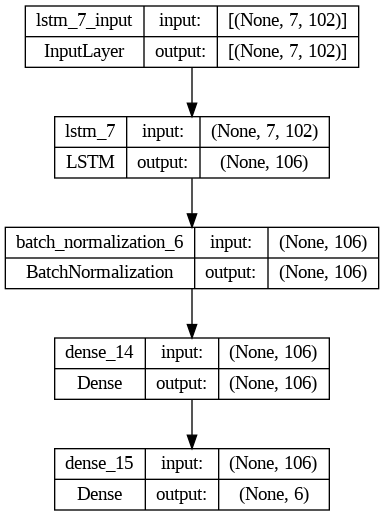

In [86]:
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 106)               88616     
                                                                 
 dense (Dense)               (None, 1)                 107       
                                                                 
 dense_1 (Dense)             (None, 6)                 12        
                                                                 
Total params: 88735 (346.62 KB)
Trainable params: 88735 (346.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
import pandas as pd

dfhistory = pd.DataFrame()

for i in range(len(history_)):
    # Obtenemos el historial de entrenamiento del modelo actual
    history_data = pd.DataFrame(history_[i].history)

    history_data['fold'] = i

    # Agregamos el historial de entrenamiento al DataFrame principal
    dfhistory = dfhistory.append(history_data, ignore_index=True)

# Ahora dfhistory contendrá el historial de entrenamiento de todos los modelos con una columna adicional llamada 'fold'
dfhistory.to_csv(project_path+f'/Resultados/{arch}_historyComplete.csv',index=False)

<ipython-input-42-fb03214f578d>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfhistory = dfhistory.append(history_data, ignore_index=True)
<ipython-input-42-fb03214f578d>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfhistory = dfhistory.append(history_data, ignore_index=True)
<ipython-input-42-fb03214f578d>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfhistory = dfhistory.append(history_data, ignore_index=True)
<ipython-input-42-fb03214f578d>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfhistory = dfhistory.append(history_data, ignore_index=True)
<ipython-input-42-fb03214f578d>:12: FutureWarning: The frame.append 

Promedio de la perdida de entrenamiento y validacion

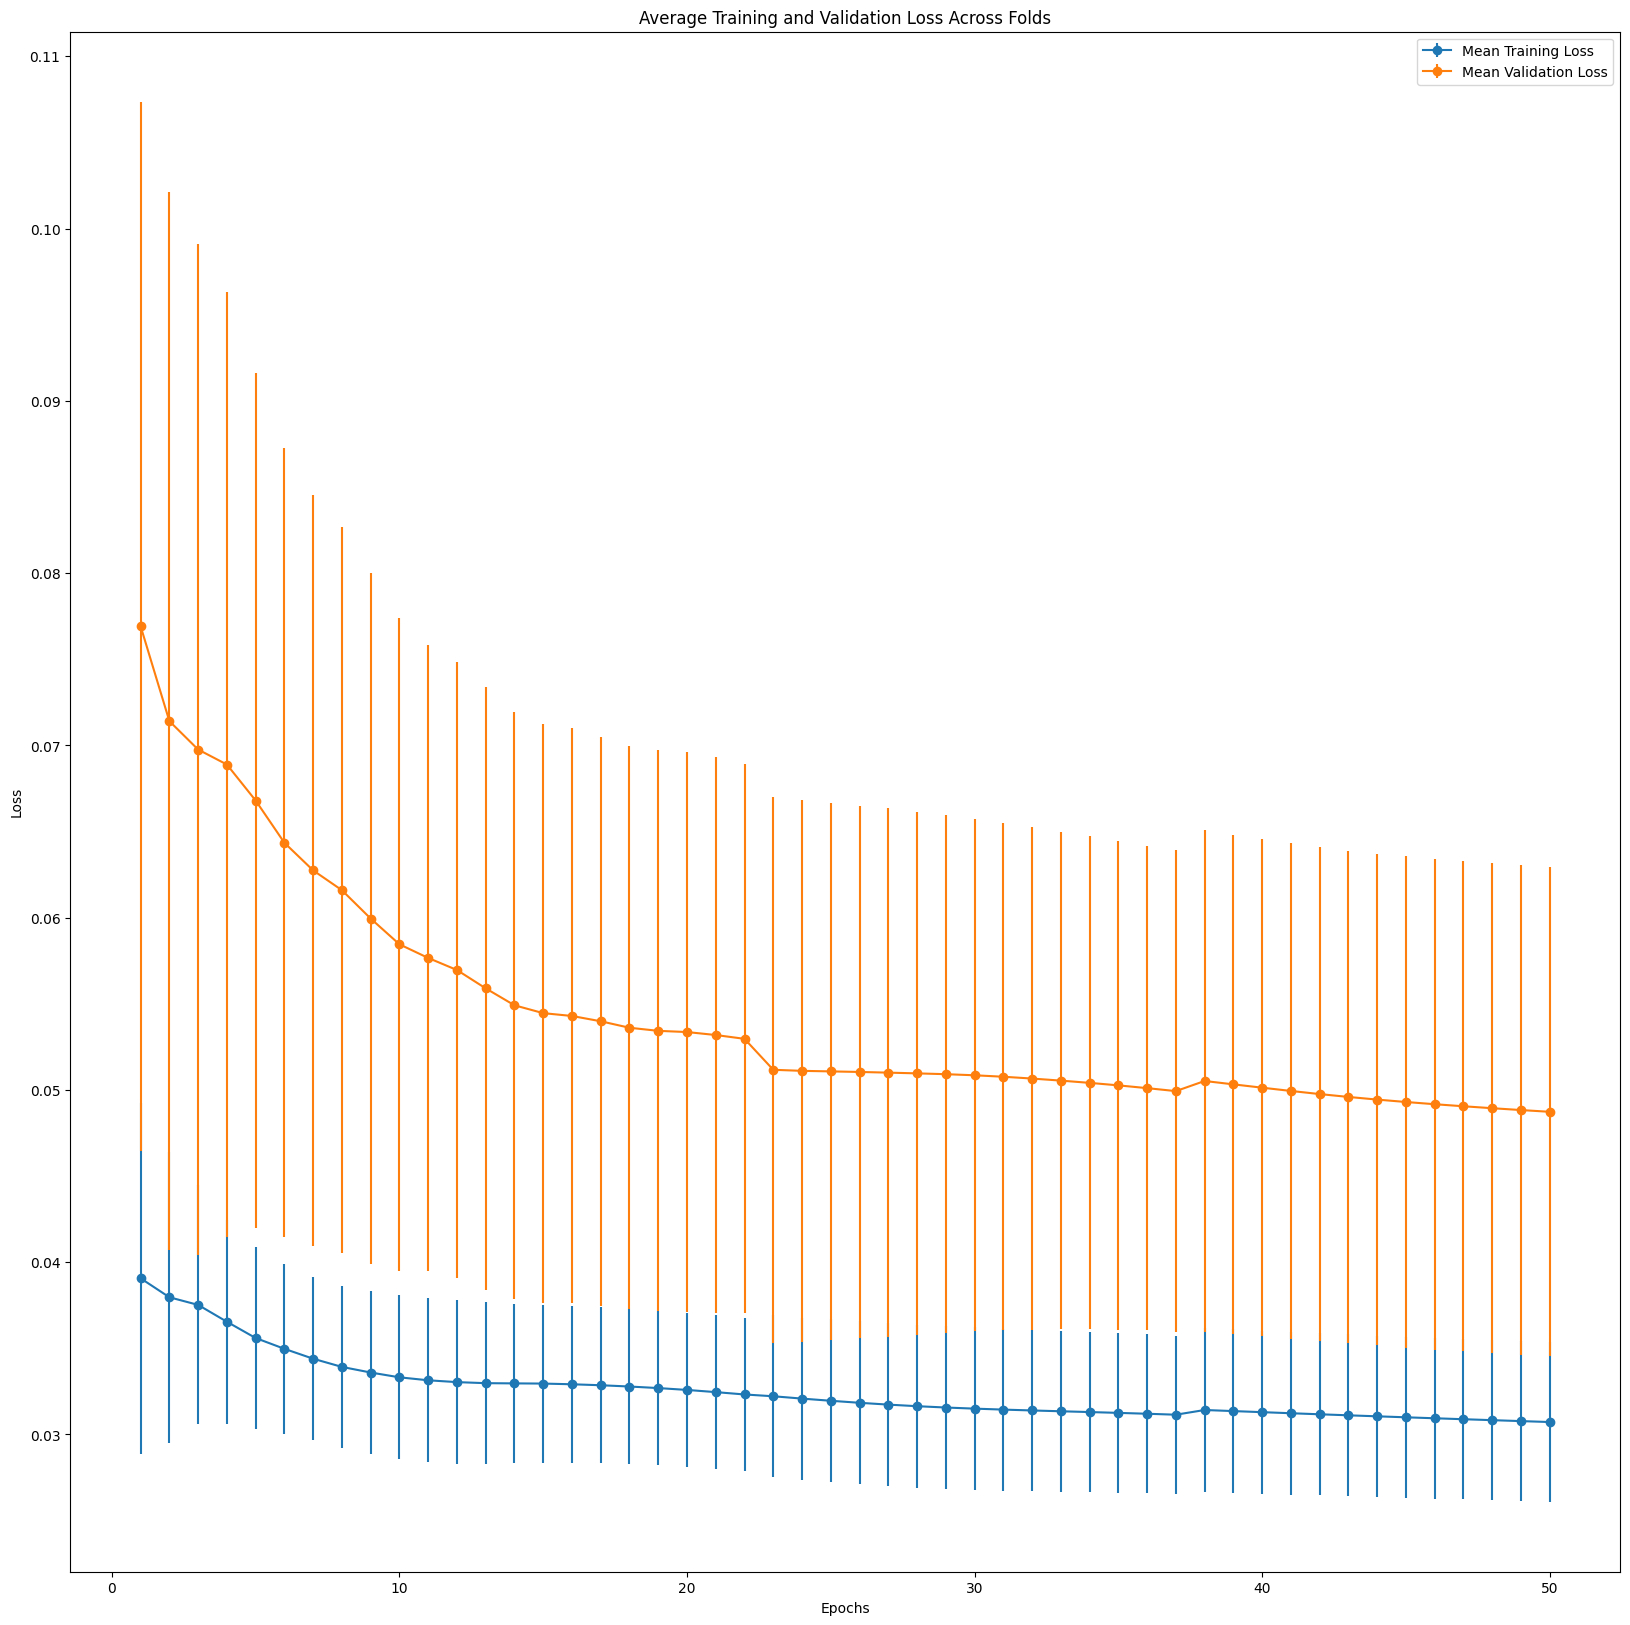

['0', '1', '2', '3', '4', '5'] done


In [44]:
max_train_epochs = max(len(losses) for losses in train_losses)
max_val_epochs = max(len(losses) for losses in val_losses)


padded_train_losses = [np.pad(losses, (0, max_train_epochs - len(losses)), mode='constant', constant_values=np.nan)
                    for losses in train_losses]

padded_val_losses = [np.pad(losses, (0, max_val_epochs - len(losses)), mode='constant', constant_values=np.nan)
                    for losses in val_losses]


mean_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)

overall_mse_train.append(np.mean(mean_train_loss))
overall_std_train.append(np.std(mean_train_loss))

mean_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

overall_mse_val.append(np.mean(mean_val_loss))
overall_std_val.append(np.std(mean_val_loss))

plt.figure(figsize=(20,20))
plt.errorbar(range(1, max_train_epochs + 1), mean_train_loss, yerr=std_train_loss, label='Mean Training Loss', marker='o')
plt.errorbar(range(1, max_val_epochs + 1), mean_val_loss, yerr=std_val_loss, label='Mean Validation Loss', marker='o')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Across Folds')


plt.legend()
plt.show()
plt.savefig(os.path.join(dir,'mean_loss.png'))
plt.close()


# %%
Taverage_mse=np.mean(t_mses)
metrics.append(Taverage_mse)
Vaverage_mse=np.mean(v_mses)
metrics.append(Vaverage_mse)
Taverage_mae=np.mean(t_maes)
metrics.append(Taverage_mae)
Vaverage_mae=np.mean(v_maes)
metrics.append(Vaverage_mae)
Taverage_mape=np.mean(t_mapes)
metrics.append(Taverage_mape)
Vaverage_mape=np.mean(v_mapes)
metrics.append(Vaverage_mape)
Taverage_rmse=np.mean(t_rmses)
metrics.append(Taverage_rmse)
Vaverage_rmse=np.mean(v_rmses)
metrics.append(Vaverage_rmse)
Taverage_mpe=np.mean(t_mpes)
metrics.append(Taverage_mpe)
Vaverage_mpe=np.mean(v_mpes)
metrics.append(Vaverage_mpe)
metrics_df[ticker_symbol]=metrics
metrics=[]
#save dataframe as csv
metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_metrics.csv',index=False)
print(f'{ticker} done')

Tstd_mse=np.std(t_mses)
Tstd_mae=np.std(t_maes)
Tstd_mape=np.std(t_mapes)
Tstd_rmse=np.std(t_rmses)
Vstd_mse=np.std(v_mses)
Vstd_mae=np.std(v_maes)
Vstd_mape=np.std(v_mapes)
Vstd_rmse=np.std(v_rmses)
Tstd_mpe=np.std(t_mpes)
Vstd_mpe=np.std(v_mpes)
std_metrics=[Tstd_mse,Tstd_mae,Tstd_mape,Tstd_rmse,Vstd_mse,Vstd_mae,Vstd_mape,Vstd_rmse,Tstd_mpe,Vstd_mpe]
std_metrics_df[ticker_symbol]=std_metrics
std_metrics_df.to_csv(project_path+f'/Resultados/metricas/{arch}_std_metrics.csv',index=False)



#define dataframe for metrics
df_ps=pd.DataFrame()
df_ps['MSE']=mse_t_p
df_ps['MAE']=mae_t_p
df_ps['MAPE']=mape_t_p
df_ps['RMSE']=rmse_t_p
df_ps['MPE']=mpe_t_p
df_ps.to_csv(project_path+f'/Resultados/metricas/{arch}_hypothesis.csv',index=False)

df_loss=pd.DataFrame()
df_loss['Training Loss']=overall_mse_train
df_loss['Training Std']=overall_std_train
df_loss['Validation Loss']=overall_mse_val
df_loss['Validation Std']=overall_std_val
df_loss.to_csv(project_path+f'/Resultados/metricas/{arch}_loss.csv',index=False)

Actividad detallada del modelo MILSTM

In [45]:

# Obtener la lista de capas del modelo
capas = model.layers

# Iterar sobre cada capa para imprimir los detalles de los parámetros
for capa in capas:
    # Imprimir el nombre de la capa
    print(f"Capa: {capa.name}")

    # Verificar si la capa tiene pesos entrenables
    if capa.trainable:
        # Obtener los pesos de la capa
        weights = capa.get_weights()

        # Imprimir los detalles de los pesos
        for i, peso in enumerate(weights):
            print(f"Peso {i + 1}:")
            print(peso.shape)  # Forma de los pesos
            print(peso)         # Valores de los pesos
    else:
        print("Esta capa no tiene pesos entrenables.")

    # Salto de línea para separar las capas
    print()

Capa: lstm
Peso 1:
(102, 424)
[[ 0.07741671  0.04223924 -0.02538145 ...  0.00107136 -0.03335847
   0.04394404]
 [-0.07894875 -0.00249884  0.08961662 ...  0.02256148  0.06300711
  -0.07727791]
 [-0.04874366 -0.04625915  0.06143938 ... -0.06163445  0.11877719
  -0.06828675]
 ...
 [-0.06500318 -0.0619796  -0.09071074 ... -0.01190854 -0.06028843
  -0.02990232]
 [-0.04652504 -0.07052915 -0.07355072 ... -0.02681176 -0.04588963
   0.10880835]
 [-0.08145941 -0.0399479   0.10011246 ... -0.06200106  0.04807162
   0.06736412]]
Peso 2:
(106, 424)
[[ 0.00481806  0.12948433 -0.02787982 ... -0.08554391 -0.00768585
   0.08487221]
 [-0.00494357 -0.00470027  0.03340136 ...  0.0615187   0.01938777
   0.00888753]
 [-0.03796244  0.0093425   0.0113269  ...  0.08424702  0.09342828
   0.03248155]
 ...
 [-0.02625413 -0.04904017  0.07707765 ...  0.02415182  0.01624133
  -0.01020655]
 [-0.03952636  0.12964594  0.02802056 ...  0.03783943  0.00140589
  -0.02098543]
 [-0.010528   -0.04646238 -0.09164535 ...  0.0918

Graficas generales de perdida de entrenamiento y validacion (SUMA PONDERADA) por cada fold

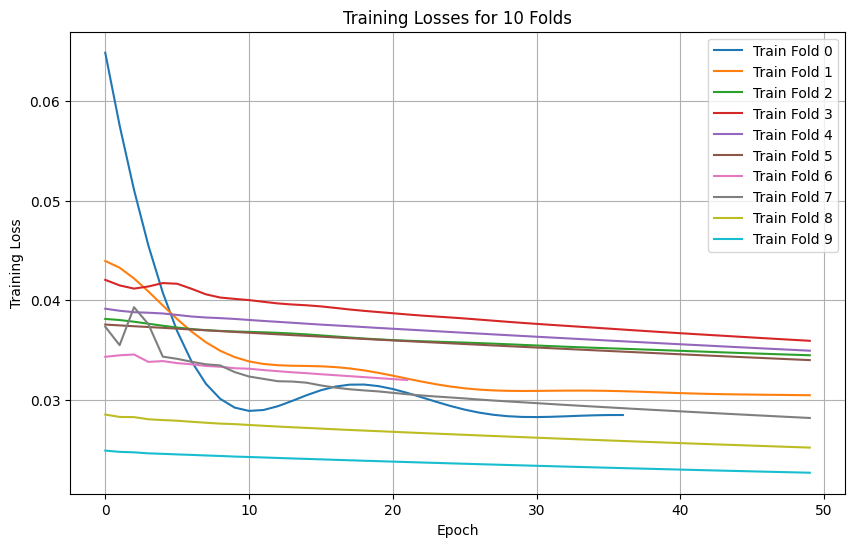

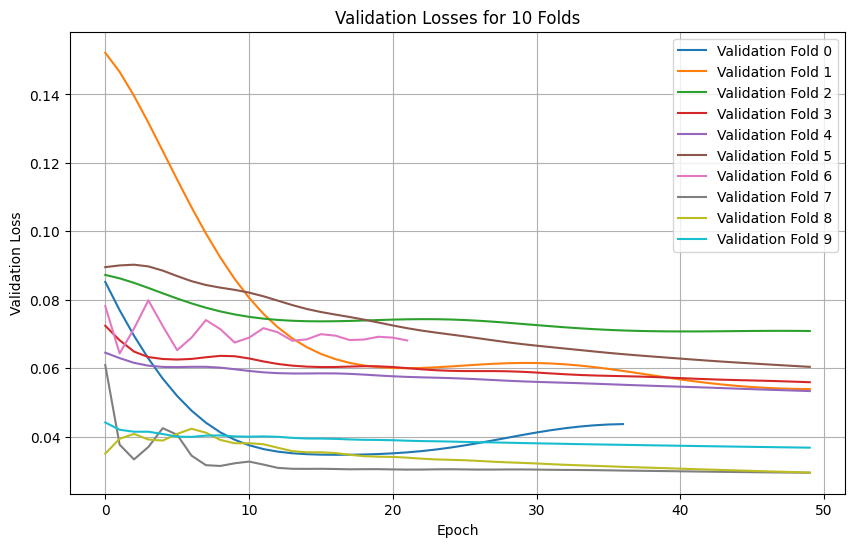

In [46]:
plt.figure(figsize=(10, 6))
# Obtener el rango total de pérdidas de entrenamiento
# min_train_loss = min([min(train_loss) for train_loss in train_losses])
# max_train_loss = max([max(train_loss) for train_loss in train_losses])

# Graficar todas las pérdidas de entrenamiento en una sola gráfica
for i in range(10):  # Suponiendo que tienes 10 folds
    plt.plot(train_losses[i], label=f'Train Fold {i}')


# Establecer los límites del eje y para abarcar todas las pérdidas
# plt.ylim(min_train_loss, max_train_loss)
# Configurar los marcadores del eje x para mostrar más segmentos pequeños
#plt.yticks(np.arange(0, 0.3, 0.02))  # Marcadores cada 0.5 unidades en el eje x

plt.title('Training Losses for 10 Folds')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid()
plt.show()

# Graficar todas las pérdidas de validación en una sola gráfica
plt.figure(figsize=(10, 6))
for i in range(10):  # Suponiendo que tienes 10 folds
    plt.plot(val_losses[i], label=f'Validation Fold {i}')

plt.title('Validation Losses for 10 Folds')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid()
plt.show()

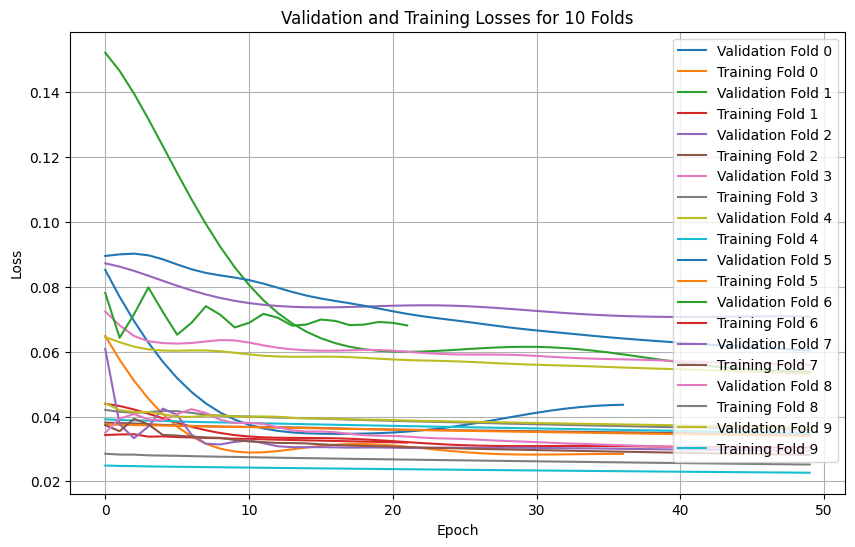

In [47]:
# Graficar todas las pérdidas de validación en una sola gráfica
plt.figure(figsize=(10, 6))
for i in range(10):  # Suponiendo que tienes 10 folds
    plt.plot(val_losses[i], label=f'Validation Fold {i}')
    plt.plot(train_losses[i], label=f'Training Fold {i}')

plt.title('Validation and Training Losses for 10 Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()